In [1]:
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import shapely
from shapely import Polygon, Point, STRtree
from shapely.wkt import dumps, loads


In [2]:
%load_ext autoreload
%autoreload 2
from mip.utils import extract_ome_tiff, listfiles, display_region

## HTAN

In [3]:
directory = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v4'


In [4]:
fps = sorted(listfiles(directory, regex='/regions.npy$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1-H1/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1_H1_06252022/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A1/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A4/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H3/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H2A2/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H3A1/outputs/regions.npy']

In [5]:
sample_to_imgs = {}
for fp in fps:
    sample = fp.split('/')[-3]
    d = np.load(fp, allow_pickle=True)[()]
    sample_to_imgs[sample] = d
    

In [6]:
fps = sorted(listfiles(directory, regex='/grid_regions.npy$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1-H1/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1_H1_06252022/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A1/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A4/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H3/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H2A2/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H3A1/outputs/grid_regions.npy']

In [7]:
sample_to_grid_imgs = {}
for fp in fps:
    sample = fp.split('/')[-3]
    d = np.load(fp, allow_pickle=True)[()]
    sample_to_grid_imgs[sample] = d

In [8]:
fps = sorted(listfiles(directory, regex='/grid_polygons.json$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1-H1/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1_H1_06252022/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A1/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A4/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H3/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H2A2/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H3A1/outputs/grid_polygons.json']

In [9]:
sample_to_polys = {}
for fp in fps:
    sample = fp.split('/')[-3]
    d = json.load(open(fp))
    sample_to_polys[sample] = d

In [10]:
fps = sorted(listfiles(directory, regex='region_metrics.txt$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1-H1/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT206B1_H1_06252022/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A1/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H1A4/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT323B1-H3/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H2A2/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v3/HT397B1-H3A1/outputs/region_metrics.txt']

In [11]:
sample_to_df = {}
for fp in fps:
    sample = fp.split('/')[-3]
    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['sample'] = sample
    df.index = [f'{sample}_{i}' for i, s in zip(df.index, df['sample'])]
    
    sample_to_df[sample] = df
    
cols = sorted({c for df in sample_to_df.values() for c in df.columns})
combined = None
for s, df in sample_to_df.items():
    missing = set(cols) - set(df.columns)
    for c in missing:
        df[c] = np.nan
    df = df[cols]
    
    if combined is None:
        combined = df
    else:
        combined = pd.concat((combined, df), axis=0)
        
combined

boundary_area  boundary_bbox-0  boundary_bbox-1  \
HT206B1-H1_1              258941                0             3350   
HT206B1-H1_2             3071313                0             5816   
HT206B1-H1_3                8759                0             7241   
HT206B1-H1_4                4634                0             7383   
HT206B1-H1_5              252262                0            10213   
...                          ...              ...              ...   
HT397B1-H3A1_1369          52321            19910               70   
HT397B1-H3A1_1370          29044            20021             6808   
HT397B1-H3A1_1371          27874            20040            10396   
HT397B1-H3A1_1372           9765            20026             7026   
HT397B1-H3A1_1373           7613            20089             7022   

                   boundary_bbox-2  boundary_bbox-3  \
HT206B1-H1_1                   443             4802   
HT206B1-H1_2                  3550            10311   
HT206B1-H1_3                    73             7396   
HT206B1-H1_4                    73             7483   
HT206B1-H1_5                   906            11243   
...                            ...              ...   
HT397B1-H3A1_1369            20160              384   
HT397B1-H3A1_1370            20160             7168   
HT397B1-H3A1_1371            20160            10684   
HT397B1-H3A1_1372            20148             7199   
HT397B1-H3A1_1373            20160             7217   

                   boundary_cell_type_CD4 T cell_cell_fraction  \
HT206B1-H1_1                                          0.000000   
HT206B1-H1_2                                          0.063045   
HT206B1-H1_3                                          0.000000   
HT206B1-H1_4                                          0.000000   
HT206B1-H1_5                                          0.041176   
...                                                        ...   
HT397B1-H3A1_1369                                     0.000000   
HT397B1-H3A1_1370                                     0.000000   
HT397B1-H3A1_1371                                     0.000000   
HT397B1-H3A1_1372                                     0.000000   
HT397B1-H3A1_1373                                     0.000000   

                   boundary_cell_type_CD8 T cell_cell_fraction  \
HT206B1-H1_1                                          0.030303   
HT206B1-H1_2                                          0.077909   
HT206B1-H1_3                                          0.000000   
HT206B1-H1_4                                          0.000000   
HT206B1-H1_5                                          0.000000   
...                                                        ...   
HT397B1-H3A1_1369                                     0.000000   
HT397B1-H3A1_1370                                     0.000000   
HT397B1-H3A1_1371                                     0.000000   
HT397B1-H3A1_1372                                     0.000000   
HT397B1-H3A1_1373                                     0.000000   

                   boundary_cell_type_Endothelial_cell_fraction  \
HT206B1-H1_1                                           0.000000   
HT206B1-H1_2                                           0.130702   
HT206B1-H1_3                                           0.000000   
HT206B1-H1_4                                           0.000000   
HT206B1-H1_5                                           0.141176   
...                                                         ...   
HT397B1-H3A1_1369                                      0.500000   
HT397B1-H3A1_1370                                      0.000000   
HT397B1-H3A1_1371                                      0.000000   
HT397B1-H3A1_1372                                      0.000000   
HT397B1-H3A1_1373                                      0.000000   

                   boundary_cell_type_Fibroblast_cell_fraction  \
HT206B1-H1_1                                          0.3333

In [12]:
{x.split('_')[0] for x in combined.columns}

{'boundary', 'expanded', 'myoepi', 'region', 'sample'}

In [13]:
region_types = ['boundary', 'expanded', 'myoepi', 'region']
weighted_mean = lambda x: np.average(x, weights=df.loc[x.index, "area"])

ignore = ['area', 'bbox', 'centroid', 'perimeter', 'grid_metrics']
# reduce to slide level
reduced = None
for rt in region_types:
    weighted_mean = lambda x: np.average(x, weights=combined.loc[x.index, f"{rt}_area"])
    cols = [c for c in combined.columns if rt == c.split('_')[0]]
    cols = [c for c in cols if not any([x in c for x in ignore])]
    cols.append('sample')
    f = combined[cols]
    f = f.replace(np.nan, 0.) # bug fixed in pipeline soon
    f = f.groupby('sample').agg(weighted_mean)
    
    sums = combined[['sample', f'{rt}_area', f'{rt}_perimeter']]
    sums = sums.groupby('sample').sum()
    f = pd.concat((f, sums), axis=1)
    
    if rt == 'myoepi':
        cols = [c for c in combined.columns if 'grid_metrics' in c]
        cols.append('sample')
        grid = combined[cols]
        grid = grid.replace(np.nan, 0.)
        grid = grid.groupby('sample').agg(weighted_mean)
        f = pd.concat((f, grid), axis=1)

    if reduced is None:
        reduced = f
    else:
        reduced = pd.concat((reduced, f), axis=1)
reduced

boundary_cell_type_CD4 T cell_cell_fraction  \
sample                                                             
HT206B1-H1                                              0.094186   
HT206B1_H1_06252022                                     0.066070   
HT323B1-H1A1                                            0.038150   
HT323B1-H1A4                                            0.050189   
HT323B1-H3                                              0.066136   
HT397B1-H2A2                                            0.013909   
HT397B1-H3A1                                            0.082519   

                     boundary_cell_type_CD8 T cell_cell_fraction  \
sample                                                             
HT206B1-H1                                              0.113186   
HT206B1_H1_06252022                                     0.098783   
HT323B1-H1A1                                            0.072743   
HT323B1-H1A4                                            0.068141   
HT323B1-H3                                              0.102452   
HT397B1-H2A2                                            0.037037   
HT397B1-H3A1                                            0.079664   

                     boundary_cell_type_Endothelial_cell_fraction  \
sample                                                              
HT206B1-H1                                               0.084778   
HT206B1_H1_06252022                                      0.092079   
HT323B1-H1A1                                             0.060558   
HT323B1-H1A4                                             0.073305   
HT323B1-H3                                               0.068035   
HT397B1-H2A2                                             0.167065   
HT397B1-H3A1                                             0.098208   

                     boundary_cell_type_Fibroblast_cell_fraction  \
sample                                                             
HT206B1-H1                                              0.305346   
HT206B1_H1_06252022                                     0.254277   
HT323B1-H1A1                                            0.354846   
HT323B1-H1A4                                            0.451161   
HT323B1-H3                                              0.335792   
HT397B1-H2A2                                            0.329424   
HT397B1-H3A1                                            0.382596   

                     boundary_cell_type_Macrophage - M1_cell_fraction  \
sample                                                                  
HT206B1-H1                                                   0.126799   
HT206B1_H1_06252022                                          0.087672   
HT323B1-H1A1                                                 0.073047   
HT323B1-H1A4                                                 0.063377   
HT323B1-H3                                                   0.141291   
HT397B1-H2A2                                                 0.074834   
HT397B1-H3A1                                                 0.111161   

                     boundary_cell_type_Macrophage - M2_cell_fraction  \
sample                                                                  
HT206B1-H1                                                   0.034518   
HT206B1_H1_06252022                                          0.032390   
HT323B1-H1A1                                                 0.027693   
HT323B1-H1A4                                                 0.044628   
HT323B1-H3                                                   0.014021   
HT397B1-H2A2                                                 0.047614   
HT397B1-H3A1                                                 0.037204   

                     boundary_cell_type_Myoepithelial_cell_fraction  \
sample                                                                
HT206B1-H1                                                 0.035274   
HT206B1_H1_06252022            

In [14]:
list(reduced.columns)

['boundary_cell_type_CD4 T cell_cell_fraction',
 'boundary_cell_type_CD8 T cell_cell_fraction',
 'boundary_cell_type_Endothelial_cell_fraction',
 'boundary_cell_type_Fibroblast_cell_fraction',
 'boundary_cell_type_Macrophage - M1_cell_fraction',
 'boundary_cell_type_Macrophage - M2_cell_fraction',
 'boundary_cell_type_Myoepithelial_cell_fraction',
 'boundary_cell_type_Noise_cell_fraction',
 'boundary_cell_type_Tumor_cell_fraction',
 'boundary_compactness',
 'boundary_eccentricity',
 'boundary_extent',
 'boundary_intensity_overlap_E-cadherin_Ki67',
 'boundary_intensity_overlap_E-cadherin_MGP',
 'boundary_intensity_overlap_E-cadherin_Pan-CK',
 'boundary_intensity_overlap_E-cadherin_Podoplanin',
 'boundary_intensity_overlap_E-cadherin_SMA',
 'boundary_intensity_overlap_Ki67_MGP',
 'boundary_intensity_overlap_Ki67_Pan-CK',
 'boundary_intensity_overlap_Ki67_Podoplanin',
 'boundary_intensity_overlap_Ki67_SMA',
 'boundary_intensity_overlap_MGP_Pan-CK',
 'boundary_intensity_overlap_MGP_Podopla

In [15]:
morphological = [
    'region_compactness',
    'region_area',
    'region_perimeter'
]
df = reduced[morphological]
df

region_compactness  region_area  region_perimeter
sample                                                                
HT206B1-H1                     0.172226     57632515      4.926202e+05
HT206B1_H1_06252022            0.172740     55540122      6.318171e+05
HT323B1-H1A1                   0.220260     29908493      1.153781e+06
HT323B1-H1A4                   0.206681     34070286      1.084760e+06
HT323B1-H3                     0.196203     42287216      1.562506e+06
HT397B1-H2A2                   0.282446     64933895      6.782244e+05
HT397B1-H3A1                   0.231914     94098813      1.043462e+06

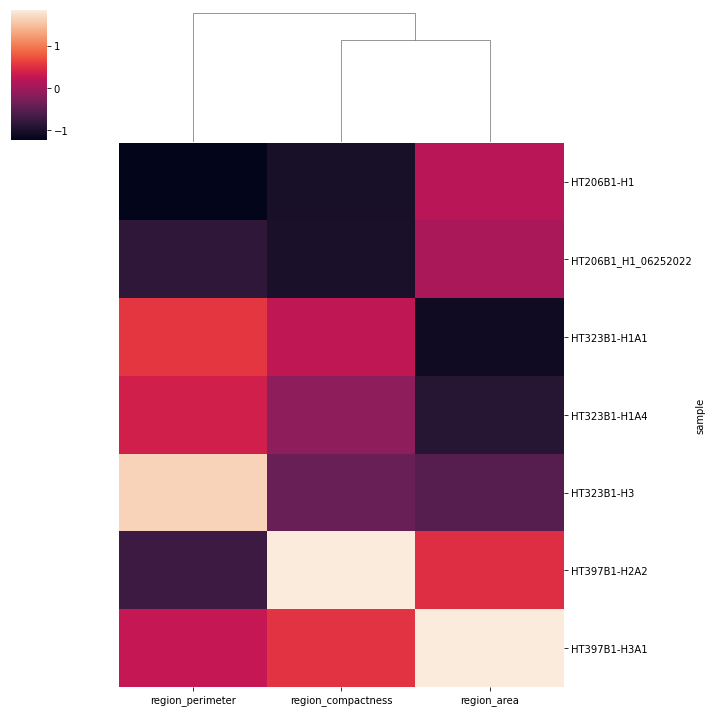

In [16]:
import seaborn as sns
sns.clustermap(df, row_cluster=False, z_score=True)

In [17]:
# for s, img in sample_to_img.items():
#     plt.imshow(img)
#     plt.title(s)
#     plt.show()

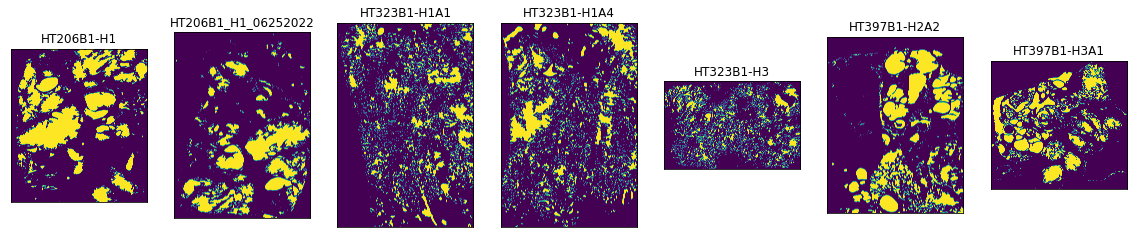

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    img = d['region']['mask']
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

In [21]:
list(reduced.columns)

['boundary_cell_type_CD4 T cell_cell_fraction',
 'boundary_cell_type_CD8 T cell_cell_fraction',
 'boundary_cell_type_Endothelial_cell_fraction',
 'boundary_cell_type_Fibroblast_cell_fraction',
 'boundary_cell_type_Macrophage - M1_cell_fraction',
 'boundary_cell_type_Macrophage - M2_cell_fraction',
 'boundary_cell_type_Myoepithelial_cell_fraction',
 'boundary_cell_type_Noise_cell_fraction',
 'boundary_cell_type_Tumor_cell_fraction',
 'boundary_compactness',
 'boundary_eccentricity',
 'boundary_extent',
 'boundary_intensity_overlap_E-cadherin_Ki67',
 'boundary_intensity_overlap_E-cadherin_MGP',
 'boundary_intensity_overlap_E-cadherin_Pan-CK',
 'boundary_intensity_overlap_E-cadherin_Podoplanin',
 'boundary_intensity_overlap_E-cadherin_SMA',
 'boundary_intensity_overlap_Ki67_MGP',
 'boundary_intensity_overlap_Ki67_Pan-CK',
 'boundary_intensity_overlap_Ki67_Podoplanin',
 'boundary_intensity_overlap_Ki67_SMA',
 'boundary_intensity_overlap_MGP_Pan-CK',
 'boundary_intensity_overlap_MGP_Podopla

In [28]:
myoepi = [
    'region_grid_metrics_Podoplanin_integrity',
    'region_grid_metrics_Podoplanin_mean_thickness_nonbreaks',
    'region_grid_metrics_SMA_integrity',
    'region_grid_metrics_SMA_mean_thickness_nonbreaks',
    'myoepi_intensity_overlap_Pan-CK_SMA',
    'myoepi_intensity_overlap_Podoplanin_SMA',
    'myoepi_intensity_overlap_E-cadherin_SMA'
]
df = reduced[myoepi]
df

region_grid_metrics_Podoplanin_integrity  \
sample                                                          
HT206B1-H1                                           0.149836   
HT206B1_H1_06252022                                  0.158099   
HT323B1-H1A1                                         0.074921   
HT323B1-H1A4                                         0.054045   
HT323B1-H3                                           0.050813   
HT397B1-H2A2                                         0.057380   
HT397B1-H3A1                                         0.039456   

                     region_grid_metrics_Podoplanin_mean_thickness_nonbreaks  \
sample                                                                         
HT206B1-H1                                                    1.295987         
HT206B1_H1_06252022                                           1.457733         
HT323B1-H1A1                                                  0.548562         
HT323B1-H1A4                                                  0.453785         
HT323B1-H3                                                    0.499517         
HT397B1-H2A2                                                  0.778267         
HT397B1-H3A1                                                  0.453404         

                     region_grid_metrics_SMA_integrity  \
sample                                                   
HT206B1-H1                                    0.472957   
HT206B1_H1_06252022                           0.439225   
HT323B1-H1A1                                  0.265984   
HT323B1-H1A4                                  0.312022   
HT323B1-H3                                    0.467014   
HT397B1-H2A2                                  0.157255   
HT397B1-H3A1                                  0.025299   

                     region_grid_metrics_SMA_mean_thickness_nonbreaks  \
sample                                                                  
HT206B1-H1                                                   2.823454   
HT206B1_H1_06252022                                          2.676857   
HT323B1-H1A1                                                 1.471560   
HT323B1-H1A4                                                 1.554071   
HT323B1-H3                                                   2.229225   
HT397B1-H2A2                                                 1.123543   
HT397B1-H3A1                                                 0.410110   

                     myoepi_intensity_overlap_Pan-CK_SMA  \
sample                                                     
HT206B1-H1                                      0.007504   
HT206B1_H1_06252022                             0.005753   
HT323B1-H1A1                                    0.003526   
HT323B1-H1A4                                    0.004183   
HT323B1-H3                                      0.005686   
HT397B1-H2A2                                    0.007435   
HT397B1-H3A1                                    0.002059   

                     myoepi_intensity_overlap_Podoplanin_SMA  \
sample                                                         
HT206B1-H1                                          0.021205   
HT206B1_H1_06252022                                 0.032146   
HT323B1-H1A1                                        0.007005   
HT323B1-H1A4                                        0.006024   
HT323B1-H3                                          0.008824   
HT397B1-H2A2                                        0.003586   
HT397B1-H3A1                                        0.001189   

                     myoepi_intensity_overlap_E-cadherin_SMA  
sample                                                        
HT206B1-H1                                          0.006340  
HT206B1_H1_06252022                                 0.023189  
HT323B1-H1A1                                        0.008127  
HT323B1-H1A4                                        0.006748  
HT323B1-H3                           

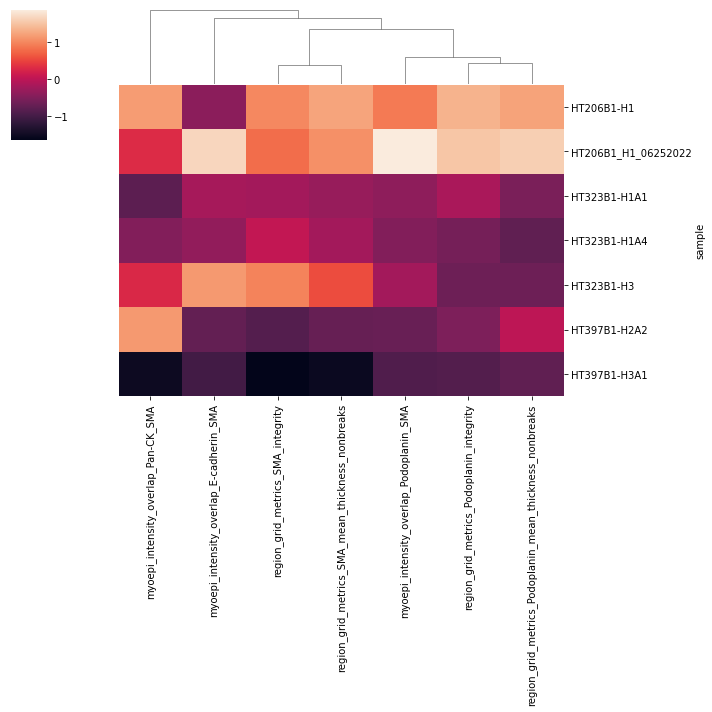

In [29]:
sns.clustermap(df, row_cluster=False, z_score=True)

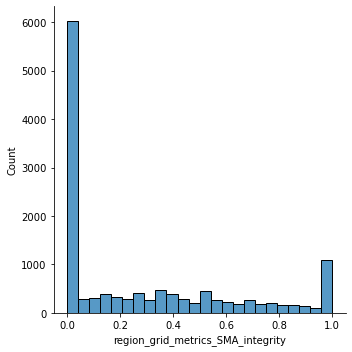

In [30]:
sns.displot(combined['region_grid_metrics_SMA_integrity'])

In [18]:
region_to_bbox = {reg:(r1, c1, r2, c2) for reg, r1, c1, r2, c2 in zip(
                    combined.index.to_list(),
                    combined['boundary_bbox-0'], combined['boundary_bbox-1'],
                    combined['boundary_bbox-2'], combined['boundary_bbox-3'])}

In [19]:
sample_to_imgs.keys()

dict_keys(['HT206B1-H1', 'HT206B1_H1_06252022', 'HT323B1-H1A1', 'HT323B1-H1A4', 'HT323B1-H3', 'HT397B1-H2A2', 'HT397B1-H3A1'])

In [20]:
def get_display_image(s, labeled, region_to_bbox,
                      color='region_grid_metrics_SMA_integrity', cmap='viridis', df=None):
    if df is None:
        df = combined

    f = df[df['sample']==s]
    f.index = [x.split('_')[-1] for x in f.index]
    rbbox = {reg.split('_')[-1]:tup for reg, tup in region_to_bbox.items() if s in reg}
    region_to_val = {reg:v
                     for reg, v in zip(f.index, f[color])}
    rgba = display_region(labeled, region_to_val, rbbox, cmap=cmap)
    return rgba

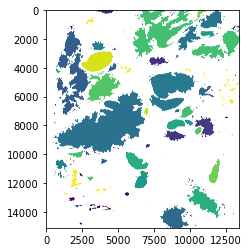

In [31]:
s = 'HT206B1-H1'
labeled = sample_to_imgs[s]['region']['labeled']
rgba = get_display_image(s, labeled)
plt.imshow(rgba)

###### sanity checking

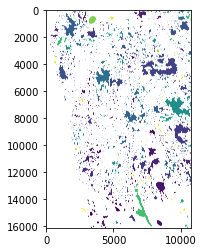

In [33]:
s = 'HT323B1-H1A1'
labeled = sample_to_imgs[s]['region']['labeled']
rgba = get_display_image(s, labeled)
plt.imshow(rgba)

In [34]:
plt.imsave('/diskmnt/Projects/Users/estorrs/sandbox/ht323b1_h1a1_reg.png', rgba)

In [35]:
tifffile.imsave('/diskmnt/Projects/Users/estorrs/sandbox/ht323b1_h1a1_myo.tif', sample_to_imgs[s]['myoepi']['mask'])

In [ ]:
'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/htan/region_mask_filled/HT323B1-H1A1.tif'


In [213]:
sample_to_grid_imgs[s][1].keys()

dict_keys(['grid_binary_positive_regions', 'grid_labeled_regions_filtered', 'grid_labeled_regions_unfiltered'])

In [214]:
f = combined[combined['sample']==s]
tups = list(zip(f.index, f['region_area']))
tups = sorted(tups, key=lambda x: x[1], reverse=True)
tups

[('HT206B1-H1_253', 13827903),
 ('HT206B1-H1_2', 6265285),
 ('HT206B1-H1_81', 5730764),
 ('HT206B1-H1_202', 5395314),
 ('HT206B1-H1_79', 2837125),
 ('HT206B1-H1_208', 2623824),
 ('HT206B1-H1_137', 2117212),
 ('HT206B1-H1_529', 2099040),
 ('HT206B1-H1_584', 1872288),
 ('HT206B1-H1_7', 1247888),
 ('HT206B1-H1_55', 1227749),
 ('HT206B1-H1_437', 1095701),
 ('HT206B1-H1_344', 1062479),
 ('HT206B1-H1_496', 768382),
 ('HT206B1-H1_465', 712820),
 ('HT206B1-H1_386', 652111),
 ('HT206B1-H1_364', 649423),
 ('HT206B1-H1_147', 520079),
 ('HT206B1-H1_321', 458314),
 ('HT206B1-H1_468', 443032),
 ('HT206B1-H1_243', 407651),
 ('HT206B1-H1_111', 389332),
 ('HT206B1-H1_490', 360083),
 ('HT206B1-H1_82', 326673),
 ('HT206B1-H1_431', 280261),
 ('HT206B1-H1_5', 219237),
 ('HT206B1-H1_1', 215297),
 ('HT206B1-H1_163', 197387),
 ('HT206B1-H1_378', 176795),
 ('HT206B1-H1_366', 155952),
 ('HT206B1-H1_38', 125831),
 ('HT206B1-H1_326', 116538),
 ('HT206B1-H1_467', 105593),
 ('HT206B1-H1_60', 103366),
 ('HT206B1-H1_

In [228]:
r = 526
r = 253

In [216]:
combined.loc[f'{s}_{r}']

boundary_area                                                              3300563
boundary_bbox-0                                                               5373
boundary_bbox-1                                                                325
boundary_bbox-2                                                              10115
boundary_bbox-3                                                               7016
                                                                          ...     
region_metacluster_Tumor Boundary - Stroma Enriched 1_cell_fraction       0.025555
region_metacluster_Tumor Boundary - Stroma Enriched 2_cell_fraction        0.00834
region_metacluster_Tumor_cell_fraction                                    0.955442
region_perimeter                                                       44199.95718
sample                                                                  HT206B1-H1
Name: HT206B1-H1_253, Length: 271, dtype: object

In [217]:
list(zip(combined.columns, combined.loc[f'{s}_{r}']))

[('boundary_area', 3300563),
 ('boundary_bbox-0', 5373),
 ('boundary_bbox-1', 325),
 ('boundary_bbox-2', 10115),
 ('boundary_bbox-3', 7016),
 ('boundary_cell_type_CD4 T cell_cell_fraction', 0.0356321839080459),
 ('boundary_cell_type_CD8 T cell_cell_fraction', 0.0528735632183908),
 ('boundary_cell_type_Endothelial_cell_fraction', 0.1413793103448276),
 ('boundary_cell_type_Fibroblast_cell_fraction', 0.3488505747126437),
 ('boundary_cell_type_Macrophage - M1_cell_fraction', 0.1241379310344827),
 ('boundary_cell_type_Macrophage - M2_cell_fraction', 0.0310344827586206),
 ('boundary_cell_type_Myoepithelial_cell_fraction', 0.0241379310344827),
 ('boundary_cell_type_Noise_cell_fraction', 0.0212643678160919),
 ('boundary_cell_type_Tumor_cell_fraction', 0.2201149425287356),
 ('boundary_centroid-0', 7940.742398796811),
 ('boundary_centroid-1', 4109.774951121975),
 ('boundary_compactness', 0.0075753400499138),
 ('boundary_eccentricity', 0.8316635759197438),
 ('boundary_extent', 0.1040244545620211)

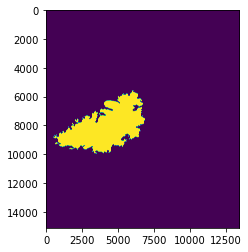

In [218]:
plt.imshow(sample_to_imgs[s]['region']['labeled']==r)

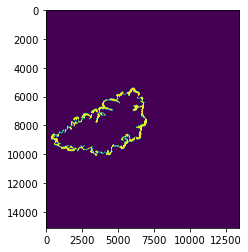

In [219]:
plt.imshow(sample_to_imgs[s]['boundary']['labeled']==r)

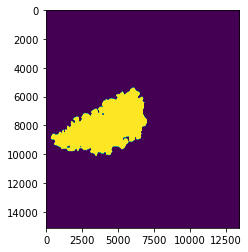

In [220]:
plt.imshow(sample_to_imgs[s]['expanded']['labeled']==r)

In [221]:
sample_to_imgs[s]['expanded']['labeled']==r

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [222]:
from skimage.measure import regionprops
from skimage.morphology import label
regions = regionprops(label(sample_to_imgs[s]['expanded']['labeled']==r))

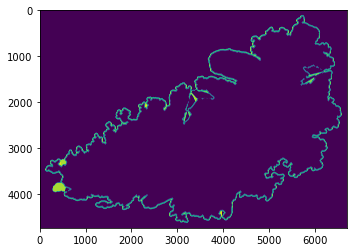

In [223]:
d = sample_to_grid_imgs[s][r]
plt.imshow(d['grid_labeled_regions_filtered'])

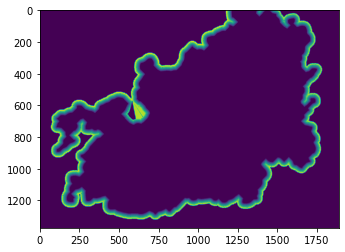

In [224]:
d = sample_to_grid_imgs[s][7]
plt.imshow(d['grid_labeled_regions_filtered'])

In [225]:
tups = []
for r, d in sample_to_polys[s].items():
    rings = d['polygons_filtered']['rings']
    rings = [p for p in loads(rings) if p.is_valid]
    tups.append((r, rings[0].length))
sorted(tups, key=lambda x: x[1], reverse=True)
    

[('81', 62018.0),
 ('2', 56214.0),
 ('253', 55338.0),
 ('202', 26708.0),
 ('79', 25130.0),
 ('208', 21002.0),
 ('529', 20740.0),
 ('55', 15862.0),
 ('584', 12134.0),
 ('344', 11842.0),
 ('7', 10274.0),
 ('468', 8246.0),
 ('137', 7446.0),
 ('147', 7446.0),
 ('490', 7422.0),
 ('386', 7376.0),
 ('437', 6988.0),
 ('465', 5970.0),
 ('243', 5814.0),
 ('496', 5812.0),
 ('5', 4846.0),
 ('111', 4836.0),
 ('364', 4734.0),
 ('82', 4168.0),
 ('60', 4140.0),
 ('321', 4138.0),
 ('38', 3734.0),
 ('431', 3650.0),
 ('163', 3600.0),
 ('1', 3578.0),
 ('218', 3416.0),
 ('583', 3320.0),
 ('59', 2422.0),
 ('188', 2386.0),
 ('366', 2204.0),
 ('581', 2182.0),
 ('378', 2098.0),
 ('198', 2064.0),
 ('579', 2060.0),
 ('467', 2030.0),
 ('544', 2004.0),
 ('181', 1920.0),
 ('560', 1916.0),
 ('326', 1846.0),
 ('571', 1790.0),
 ('512', 1750.0),
 ('328', 1728.0),
 ('141', 1652.0),
 ('123', 1616.0),
 ('289', 1604.0),
 ('167', 1592.0),
 ('435', 1584.0),
 ('238', 1526.0),
 ('191', 1510.0),
 ('203', 1506.0),
 ('173', 1474.

In [229]:
d = sample_to_polys[s][str(r)]['polygons_filtered']
d.keys()

dict_keys(['polys', 'group_lines', 'rings'])

In [ ]:
from shapely.wkt import dumps, loads
polys = [p for p in loads(d['polys']) if p.is_valid]
shapely.GeometryCollection(polys)

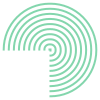

In [141]:
polys = [p for p in loads(d['rings']) if p.is_valid]
shapely.GeometryCollection(polys)

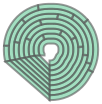

In [125]:
shapely.GeometryCollection(polys)

###### analysis

In [21]:
from skimage.transform import rescale

In [22]:
# make thumbnails so it doesn't take so long to plot
for s in sample_to_imgs.keys():
    print(s)
    for name in sample_to_imgs[s].keys():
        for k in list(sample_to_imgs[s][name].keys()):
            img = sample_to_imgs[s][name][k]
            rescaled = rescale(img, .1, preserve_range=True).round().astype(np.int32)
            sample_to_imgs[s][name][f'{k}_thumbnail'] = rescaled


HT206B1-H1
HT206B1_H1_06252022
HT323B1-H1A1
HT323B1-H1A4
HT323B1-H3
HT397B1-H2A2
HT397B1-H3A1


In [23]:
region_to_bbox_thumbnail = {k:(int(r1 * .1), int(c1 * .1), int(r2 * .1), int(c2 * .1))
                           for k, (r1, c1, r2, c2) in region_to_bbox.items()}

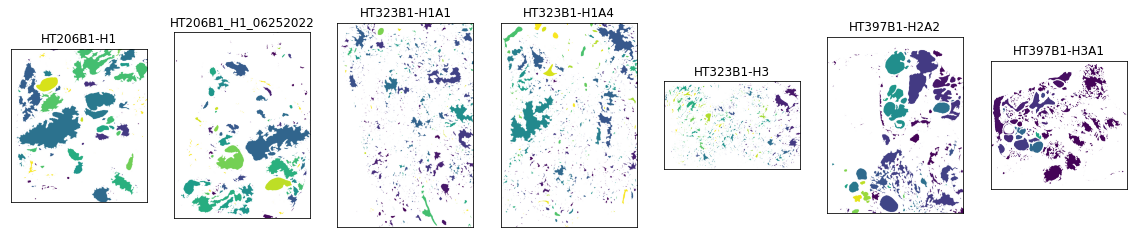

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail, color='region_grid_metrics_SMA_integrity')
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'HT206B1-H1'),
  Text(1, 0, 'HT206B1_H1_06252022'),
  Text(2, 0, 'HT323B1-H1A1'),
  Text(3, 0, 'HT323B1-H1A4'),
  Text(4, 0, 'HT323B1-H3'),
  Text(5, 0, 'HT397B1-H2A2'),
  Text(6, 0, 'HT397B1-H3A1')])

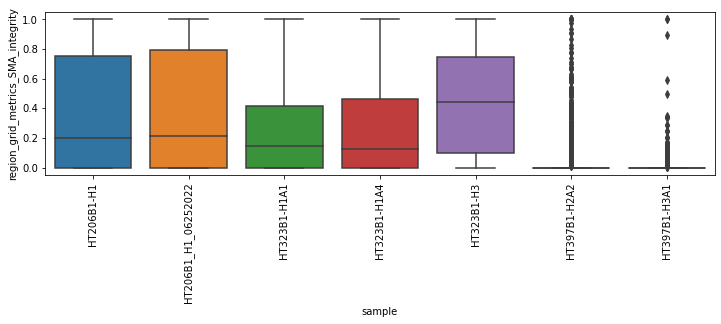

In [83]:
fig, axs = plt.subplots(figsize=(12, 3))
sns.boxplot(data=combined, x='sample', y='region_grid_metrics_SMA_integrity')
plt.xticks(rotation=90)

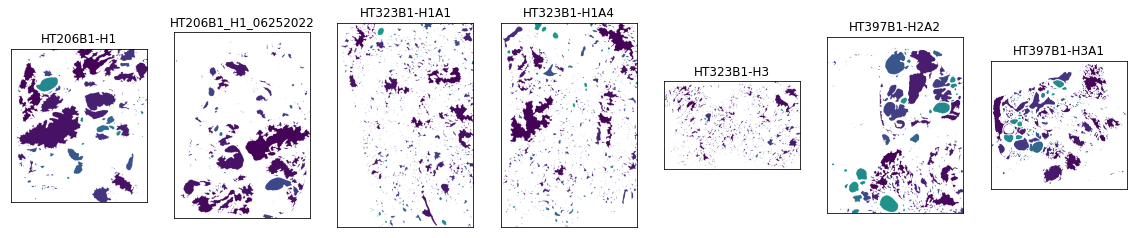

In [85]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail, color='region_compactness')
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

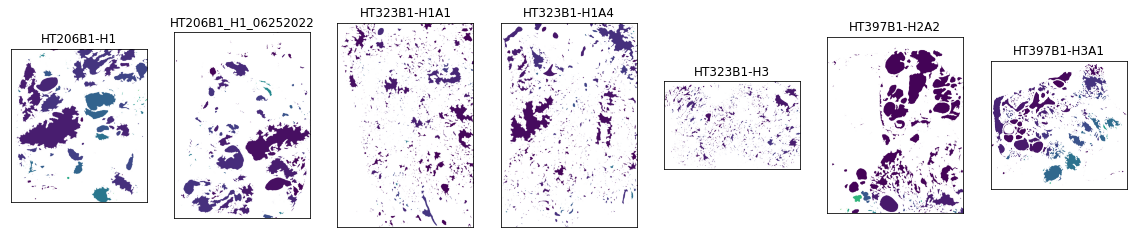

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail, color='boundary_cell_type_CD4 T cell_cell_fraction')
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

In [24]:
combined.shape

(13218, 271)

In [25]:
f = combined[combined['region_area']>100000]
f.shape

(382, 271)

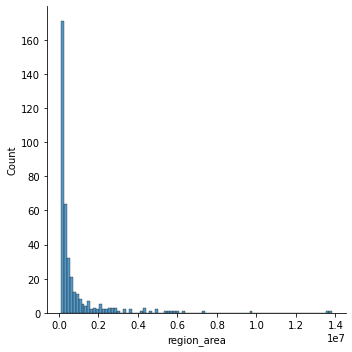

In [98]:
sns.displot(f['region_area'])

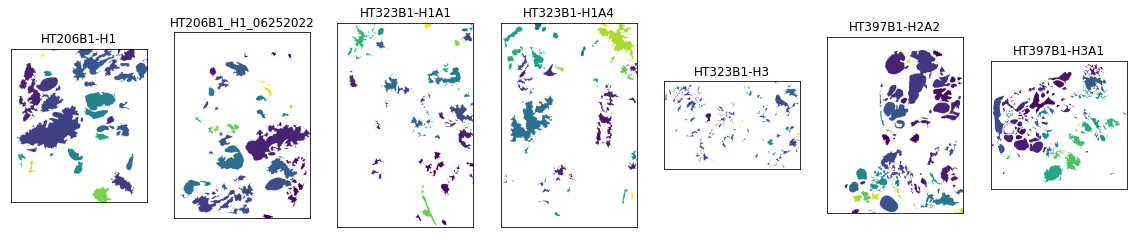

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail,
                            color='boundary_cell_type_CD8 T cell_cell_fraction', df=f)
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'HT206B1-H1'),
  Text(1, 0, 'HT206B1_H1_06252022'),
  Text(2, 0, 'HT323B1-H1A1'),
  Text(3, 0, 'HT323B1-H1A4'),
  Text(4, 0, 'HT323B1-H3'),
  Text(5, 0, 'HT397B1-H2A2'),
  Text(6, 0, 'HT397B1-H3A1')])

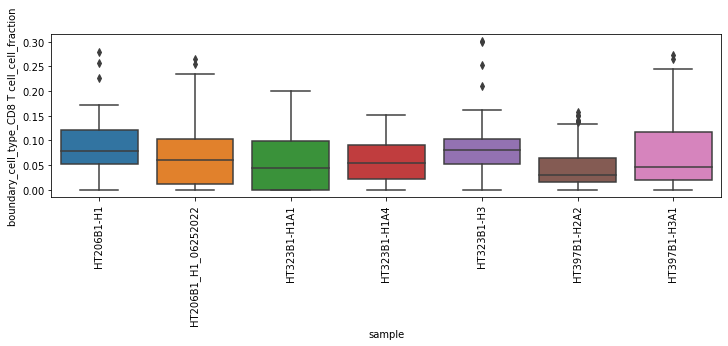

In [104]:
fig, axs = plt.subplots(figsize=(12, 3))
sns.boxplot(data=f, x='sample', y='boundary_cell_type_CD8 T cell_cell_fraction')
plt.xticks(rotation=90)

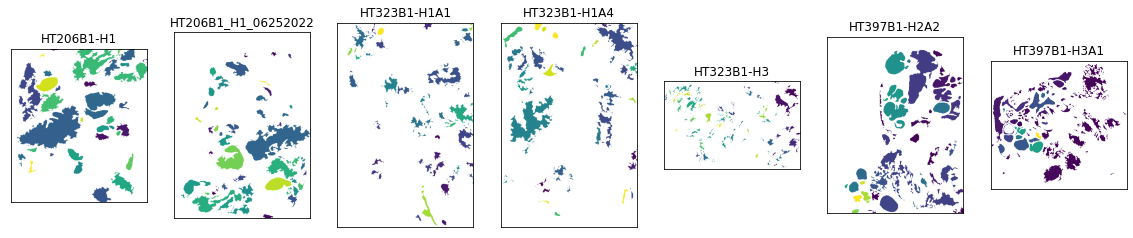

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail,
                            color='region_grid_metrics_SMA_integrity', df=f)
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'HT206B1-H1'),
  Text(1, 0, 'HT206B1_H1_06252022'),
  Text(2, 0, 'HT323B1-H1A1'),
  Text(3, 0, 'HT323B1-H1A4'),
  Text(4, 0, 'HT323B1-H3'),
  Text(5, 0, 'HT397B1-H2A2'),
  Text(6, 0, 'HT397B1-H3A1')])

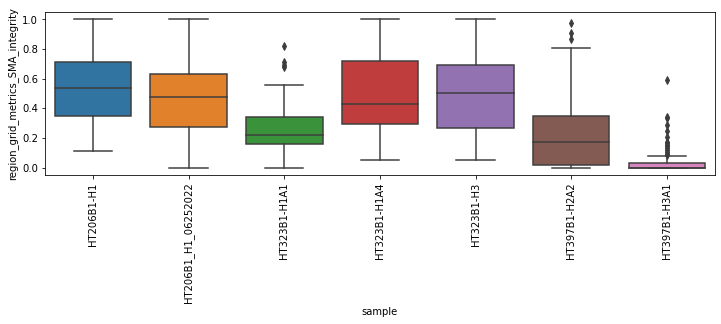

In [106]:
fig, axs = plt.subplots(figsize=(12, 3))
sns.boxplot(data=f, x='sample', y='region_grid_metrics_SMA_integrity')
plt.xticks(rotation=90)

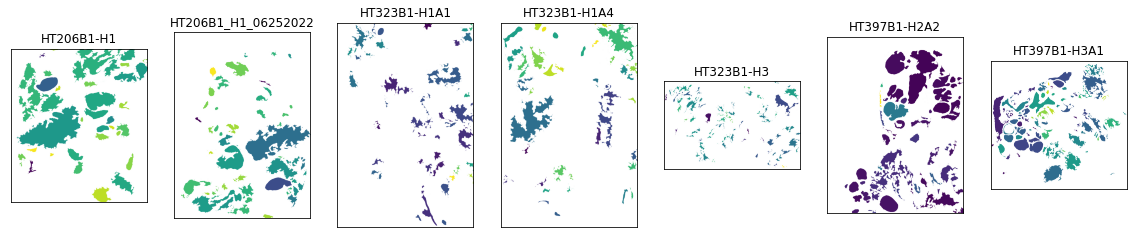

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail,
                            color='region_intensity_positive_fraction_Ki67', df=f)
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'HT206B1-H1'),
  Text(1, 0, 'HT206B1_H1_06252022'),
  Text(2, 0, 'HT323B1-H1A1'),
  Text(3, 0, 'HT323B1-H1A4'),
  Text(4, 0, 'HT323B1-H3'),
  Text(5, 0, 'HT397B1-H2A2'),
  Text(6, 0, 'HT397B1-H3A1')])

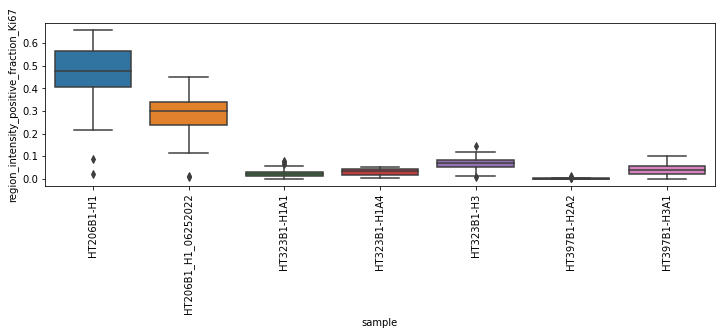

In [108]:
fig, axs = plt.subplots(figsize=(12, 3))
sns.boxplot(data=f, x='sample', y='region_intensity_positive_fraction_Ki67')
plt.xticks(rotation=90)

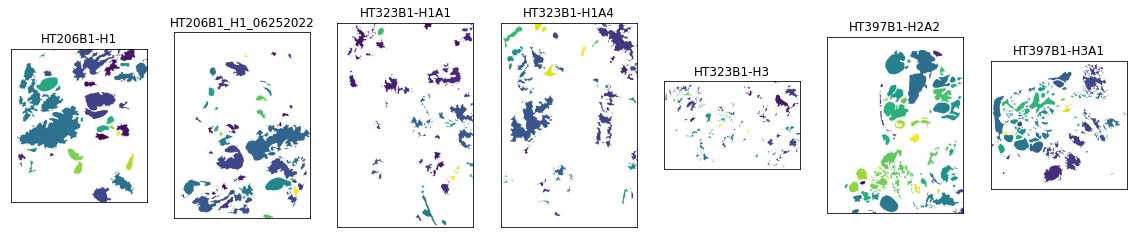

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail,
                            color='region_intensity_positive_fraction_MGP', df=f)
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'HT206B1-H1'),
  Text(1, 0, 'HT206B1_H1_06252022'),
  Text(2, 0, 'HT323B1-H1A1'),
  Text(3, 0, 'HT323B1-H1A4'),
  Text(4, 0, 'HT323B1-H3'),
  Text(5, 0, 'HT397B1-H2A2'),
  Text(6, 0, 'HT397B1-H3A1')])

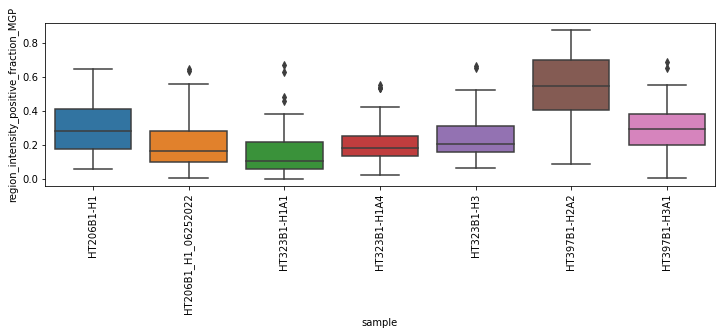

In [110]:
fig, axs = plt.subplots(figsize=(12, 3))
sns.boxplot(data=f, x='sample', y='region_intensity_positive_fraction_MGP')
plt.xticks(rotation=90)

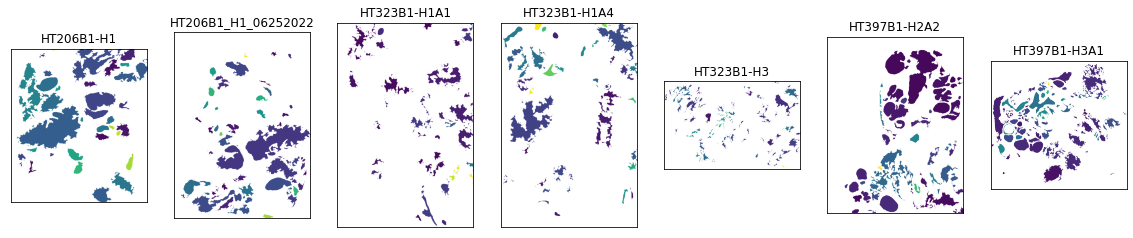

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 10))
for (s, d), ax in zip(sample_to_imgs.items(), axs):
    labeled = sample_to_imgs[s]['region']['labeled_thumbnail']
    img = get_display_image(s, labeled, region_to_bbox_thumbnail,
                            color='region_intensity_overlap_Ki67_MGP', df=f)
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'HT206B1-H1'),
  Text(1, 0, 'HT206B1_H1_06252022'),
  Text(2, 0, 'HT323B1-H1A1'),
  Text(3, 0, 'HT323B1-H1A4'),
  Text(4, 0, 'HT323B1-H3'),
  Text(5, 0, 'HT397B1-H2A2'),
  Text(6, 0, 'HT397B1-H3A1')])

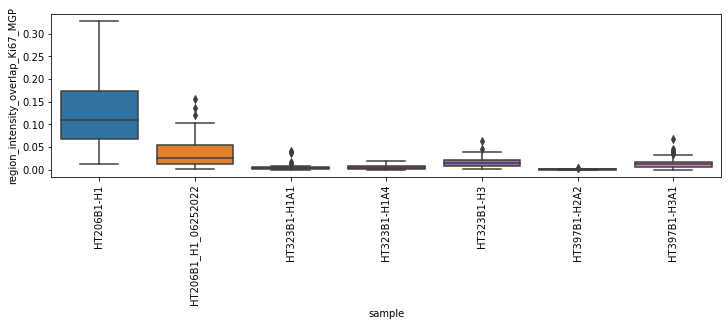

In [27]:
fig, axs = plt.subplots(figsize=(12, 3))
sns.boxplot(data=f, x='sample', y='region_intensity_overlap_Ki67_MGP')
plt.xticks(rotation=90)

<AxesSubplot:xlabel='region_intensity_positive_fraction_MGP', ylabel='region_grid_metrics_SMA_integrity'>

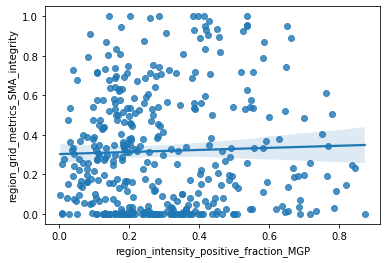

In [111]:
sns.regplot(data=f, x='region_intensity_positive_fraction_MGP', y='region_grid_metrics_SMA_integrity')

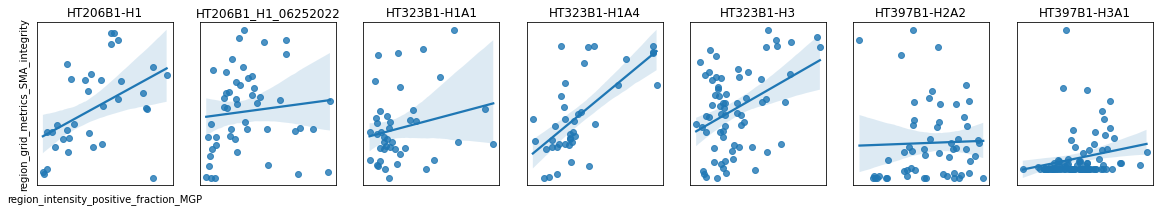

In [121]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 3))
for i, (s, ax) in enumerate(zip(sample_to_imgs, axs)):
    fs = f[f['sample']==s]
    sns.regplot(data=fs, x='region_intensity_positive_fraction_MGP', y='region_grid_metrics_SMA_integrity', ax=ax)
    ax.set_title(s)
    
    ax.set_xticks([])
    ax.set_yticks([])
    if i != 0:
        ax.set_ylabel('')
        ax.set_xlabel('')

<AxesSubplot:xlabel='region_intensity_positive_fraction_MGP', ylabel='region_compactness'>

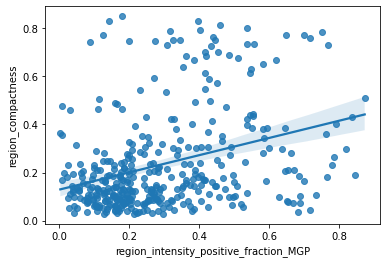

In [122]:
sns.regplot(data=f, x='region_intensity_positive_fraction_MGP', y='region_compactness')

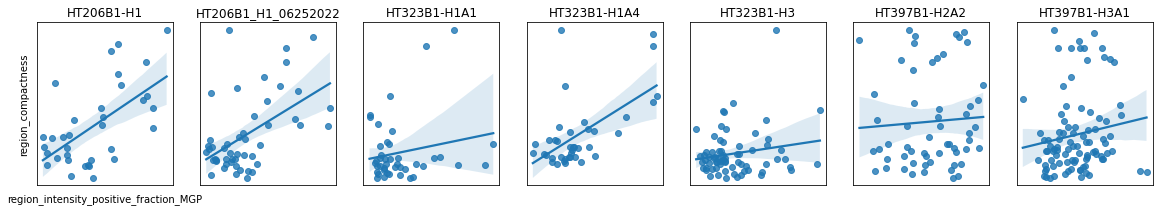

In [123]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 3))
for i, (s, ax) in enumerate(zip(sample_to_imgs, axs)):
    fs = f[f['sample']==s]
    sns.regplot(data=fs, x='region_intensity_positive_fraction_MGP', y='region_compactness', ax=ax)
    ax.set_title(s)
    
    ax.set_xticks([])
    ax.set_yticks([])
    if i != 0:
        ax.set_ylabel('')
        ax.set_xlabel('')

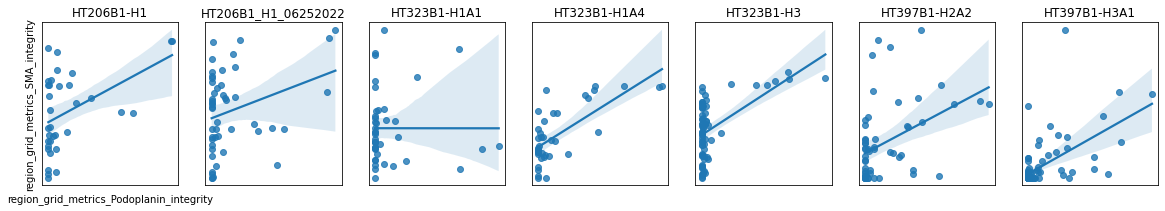

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=len(sample_to_imgs), figsize=(20, 3))
for i, (s, ax) in enumerate(zip(sample_to_imgs, axs)):
    fs = f[f['sample']==s]
    sns.regplot(data=fs, x='region_grid_metrics_Podoplanin_integrity', y='region_grid_metrics_SMA_integrity', ax=ax)
    ax.set_title(s)
    
    ax.set_xticks([])
    ax.set_yticks([])
    if i != 0:
        ax.set_ylabel('')
        ax.set_xlabel('')

In [130]:
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
X = 

In [152]:
exclude = ['bbox', 'sample']
feats = f[[c for c in f.columns if not any([True if val in c else False for val in exclude])]]
X = feats.values
X[pd.isnull(X)] = 0.
X = StandardScaler().fit_transform(X)
emb = umap.UMAP().fit_transform(X)

In [153]:
umap_df = pd.DataFrame(data=emb, columns=['UMAP1', 'UMAP2'], index=f.index)
umap_df = pd.concat((umap_df, f), axis=1)
umap_df

UMAP1     UMAP2  boundary_area  boundary_bbox-0  \
HT206B1-H1_1       11.727728  6.025928         258941                0   
HT206B1-H1_2       11.662226  4.961284        3071313                0   
HT206B1-H1_5       11.845536  5.528145         252262                0   
HT206B1-H1_7       11.910096  5.554358         488668                0   
HT206B1-H1_38      -0.388732  7.174646         417295              357   
...                      ...       ...            ...              ...   
HT397B1-H3A1_1029  -0.362228  3.331077         448238            14432   
HT397B1-H3A1_1133   1.624700  2.587837        1681921            16176   
HT397B1-H3A1_1208  -0.735126  0.634384         313644            17283   
HT397B1-H3A1_1220   2.305332  1.646118         323165            17446   
HT397B1-H3A1_1260   0.947284  2.613127         285360            18113   

                   boundary_bbox-1  boundary_bbox-2  boundary_bbox-3  \
HT206B1-H1_1                  3350              443             4802   
HT206B1-H1_2                  5816             3550            10311   
HT206B1-H1_5                 10213              906            11243   
HT206B1-H1_7                 10461             1373            12349   
HT206B1-H1_38                 2617             1110             3583   
...                            ...              ...              ...   
HT397B1-H3A1_1029             2159            15797             3162   
HT397B1-H3A1_1133             7991            19480            11548   
HT397B1-H3A1_1208             1642            17999             2598   
HT397B1-H3A1_1220            18563            18128            19631   
HT397B1-H3A1_1260            10467            19023            11331   

                   boundary_cell_type_CD4 T cell_cell_fraction  \
HT206B1-H1_1                                          0.000000   
HT206B1-H1_2                                          0.063045   
HT206B1-H1_5                                          0.041176   
HT206B1-H1_7                                          0.062222   
HT206B1-H1_38                                         0.200378   
...                                                        ...   
HT397B1-H3A1_1029                                     0.177778   
HT397B1-H3A1_1133                                     0.203631   
HT397B1-H3A1_1208                                     0.000000   
HT397B1-H3A1_1220                                     0.000000   
HT397B1-H3A1_1260                                     0.165746   

                   boundary_cell_type_CD8 T cell_cell_fraction  \
HT206B1-H1_1                                          0.030303   
HT206B1-H1_2                                          0.077909   
HT206B1-H1_5                                          0.000000   
HT206B1-H1_7                                          0.026667   
HT206B1-H1_38                                         0.279773   
...                                                        ...   
HT397B1-H3A1_1029                                     0.213333   
HT397B1-H3A1_1133                                     0.163378   
HT397B1-H3A1_1208                                     0.037037   
HT397B1-H3A1_1220                                     0.000000   
HT397B1-H3A1_1260                                     0.138122   

                   boundary_cell_type_Endothelial_cell_fraction  ...  \
HT206B1-H1_1                                           0.000000  ...   
HT206B1-H1_2                                           0.130702  ...   
HT206B1-H1_5                                           0.141176  ...   
HT206B1-H1_7                                           0.120000  ...   
HT206B1-H1_38                                          0.043478  ...   
...                                                         ...  ...   
HT397B1-H3A1_1029                                      0.093333  ...   
HT397B1-H3A1_1133                                      0.089187  ...   
HT397B1-H3A1_1208                  

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

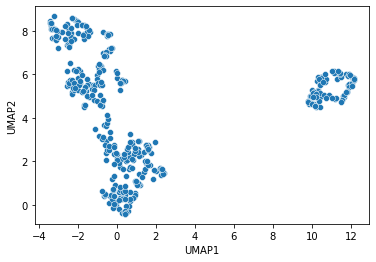

In [154]:
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2')

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

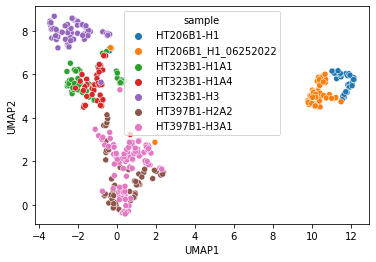

In [168]:
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='sample')

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

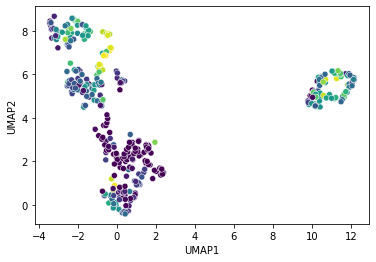

In [156]:
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='region_grid_metrics_SMA_integrity',
                palette='viridis', legend=False)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

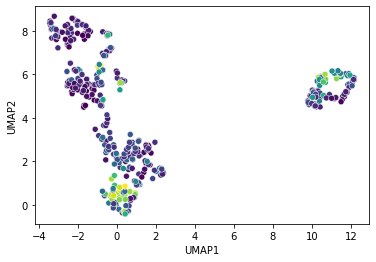

In [167]:
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='region_compactness',
                palette='viridis', legend=False)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

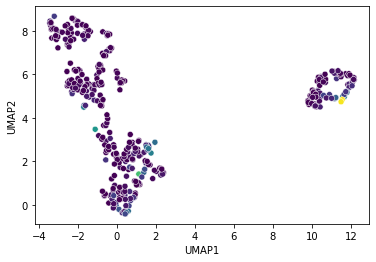

In [165]:
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='region_area', vmax=1.,
                palette='viridis', legend=False)

In [166]:
umap_df

UMAP1     UMAP2  boundary_area  boundary_bbox-0  \
HT206B1-H1_1       11.727728  6.025928         258941                0   
HT206B1-H1_2       11.662226  4.961284        3071313                0   
HT206B1-H1_5       11.845536  5.528145         252262                0   
HT206B1-H1_7       11.910096  5.554358         488668                0   
HT206B1-H1_38      -0.388732  7.174646         417295              357   
...                      ...       ...            ...              ...   
HT397B1-H3A1_1029  -0.362228  3.331077         448238            14432   
HT397B1-H3A1_1133   1.624700  2.587837        1681921            16176   
HT397B1-H3A1_1208  -0.735126  0.634384         313644            17283   
HT397B1-H3A1_1220   2.305332  1.646118         323165            17446   
HT397B1-H3A1_1260   0.947284  2.613127         285360            18113   

                   boundary_bbox-1  boundary_bbox-2  boundary_bbox-3  \
HT206B1-H1_1                  3350              443             4802   
HT206B1-H1_2                  5816             3550            10311   
HT206B1-H1_5                 10213              906            11243   
HT206B1-H1_7                 10461             1373            12349   
HT206B1-H1_38                 2617             1110             3583   
...                            ...              ...              ...   
HT397B1-H3A1_1029             2159            15797             3162   
HT397B1-H3A1_1133             7991            19480            11548   
HT397B1-H3A1_1208             1642            17999             2598   
HT397B1-H3A1_1220            18563            18128            19631   
HT397B1-H3A1_1260            10467            19023            11331   

                   boundary_cell_type_CD4 T cell_cell_fraction  \
HT206B1-H1_1                                          0.000000   
HT206B1-H1_2                                          0.063045   
HT206B1-H1_5                                          0.041176   
HT206B1-H1_7                                          0.062222   
HT206B1-H1_38                                         0.200378   
...                                                        ...   
HT397B1-H3A1_1029                                     0.177778   
HT397B1-H3A1_1133                                     0.203631   
HT397B1-H3A1_1208                                     0.000000   
HT397B1-H3A1_1220                                     0.000000   
HT397B1-H3A1_1260                                     0.165746   

                   boundary_cell_type_CD8 T cell_cell_fraction  \
HT206B1-H1_1                                          0.030303   
HT206B1-H1_2                                          0.077909   
HT206B1-H1_5                                          0.000000   
HT206B1-H1_7                                          0.026667   
HT206B1-H1_38                                         0.279773   
...                                                        ...   
HT397B1-H3A1_1029                                     0.213333   
HT397B1-H3A1_1133                                     0.163378   
HT397B1-H3A1_1208                                     0.037037   
HT397B1-H3A1_1220                                     0.000000   
HT397B1-H3A1_1260                                     0.138122   

                   boundary_cell_type_Endothelial_cell_fraction  ...  \
HT206B1-H1_1                                           0.000000  ...   
HT206B1-H1_2                                           0.130702  ...   
HT206B1-H1_5                                           0.141176  ...   
HT206B1-H1_7                                           0.120000  ...   
HT206B1-H1_38                                          0.043478  ...   
...                                                         ...  ...   
HT397B1-H3A1_1029                                      0.093333  ...   
HT397B1-H3A1_1133                                      0.089187  ...   
HT397B1-H3A1_1208                  

In [144]:
umap_df['region_grid_metrics_SMA_integrity']

HT206B1-H1_1         0.109244
HT206B1-H1_2         0.715517
HT206B1-H1_5         0.810185
HT206B1-H1_7         0.389418
HT206B1-H1_38        1.000000
                       ...   
HT397B1-H3A1_1029    0.000000
HT397B1-H3A1_1133    0.006768
HT397B1-H3A1_1208    0.000000
HT397B1-H3A1_1220    0.000000
HT397B1-H3A1_1260    0.000000
Name: region_grid_metrics_SMA_integrity, Length: 382, dtype: float64

In [86]:
list(combined.columns)

['boundary_area',
 'boundary_bbox-0',
 'boundary_bbox-1',
 'boundary_bbox-2',
 'boundary_bbox-3',
 'boundary_cell_type_CD4 T cell_cell_fraction',
 'boundary_cell_type_CD8 T cell_cell_fraction',
 'boundary_cell_type_Endothelial_cell_fraction',
 'boundary_cell_type_Fibroblast_cell_fraction',
 'boundary_cell_type_Macrophage - M1_cell_fraction',
 'boundary_cell_type_Macrophage - M2_cell_fraction',
 'boundary_cell_type_Myoepithelial_cell_fraction',
 'boundary_cell_type_Noise_cell_fraction',
 'boundary_cell_type_Tumor_cell_fraction',
 'boundary_centroid-0',
 'boundary_centroid-1',
 'boundary_compactness',
 'boundary_eccentricity',
 'boundary_extent',
 'boundary_intensity_overlap_E-cadherin_Ki67',
 'boundary_intensity_overlap_E-cadherin_MGP',
 'boundary_intensity_overlap_E-cadherin_Pan-CK',
 'boundary_intensity_overlap_E-cadherin_Podoplanin',
 'boundary_intensity_overlap_E-cadherin_SMA',
 'boundary_intensity_overlap_Ki67_MGP',
 'boundary_intensity_overlap_Ki67_Pan-CK',
 'boundary_intensity_ov

## Angelo

In [3]:
directory = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4'


In [4]:
fps = sorted(listfiles(directory, regex='region_metrics.txt$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2203/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2204/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2302/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2303/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2304/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2305/outputs/region_metrics.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2306/outpu

In [5]:
sample_to_df = {}
for fp in fps:
    sample = fp.split('/')[-3]
    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['sample'] = sample
    df.index = [f'{sample}_{i}' for i, s in zip(df.index, df['sample'])]
    
    sample_to_df[sample] = df
    
cols = sorted({c for df in sample_to_df.values() for c in df.columns})
combined = None
for s, df in sample_to_df.items():
    missing = set(cols) - set(df.columns)
    for c in missing:
        df[c] = np.nan
    df = df[cols]
    
    if combined is None:
        combined = df
    else:
        combined = pd.concat((combined, df), axis=0)
        
combined

boundary_area  boundary_bbox-0  boundary_bbox-1  \
Point2203_1          175653                0              347   
Point2204_1          108756                0              392   
Point2204_2           73987              424                0   
Point2204_3          152823              586              233   
Point2204_4           43529              806                0   
...                     ...              ...              ...   
Point6204_12          28640              479              419   
Point6204_13          89514              567                0   
Point6204_14          67115              608              539   
Point6206_1          198693                0                0   
Point6206_2           70004              745                0   

              boundary_bbox-2  boundary_bbox-3  \
Point2203_1              1024              725   
Point2204_1               341              918   
Point2204_2               747              279   
Point2204_3              1024              813   
Point2204_4              1024              286   
...                       ...              ...   
Point6204_12              684              627   
Point6204_13             1024              877   
Point6204_14              898              950   
Point6206_1               712              871   
Point6206_2              1024              436   

              boundary_cell_type_APC_cell_fraction  \
Point2203_1                               0.011111   
Point2204_1                               0.024390   
Point2204_2                               0.166667   
Point2204_3                               0.027778   
Point2204_4                               0.000000   
...                                            ...   
Point6204_12                              0.047619   
Point6204_13                              0.000000   
Point6204_14                              0.069767   
Point6206_1                               0.125926   
Point6206_2                               0.171053   

              boundary_cell_type_BCELL_cell_fraction  \
Point2203_1                                 0.000000   
Point2204_1                                 0.000000   
Point2204_2                                 0.000000   
Point2204_3                                 0.000000   
Point2204_4                                 0.000000   
...                                              ...   
Point6204_12                                0.000000   
Point6204_13                                0.000000   
Point6204_14                                0.139535   
Point6206_1                                 0.007407   
Point6206_2                                 0.000000   

              boundary_cell_type_CAF_cell_fraction  \
Point2203_1                               0.111111   
Point2204_1                               0.000000   
Point2204_2                               0.138889   
Point2204_3                               0.152778   
Point2204_4                               0.000000   
...                                            ...   
Point6204_12                              0.047619   
Point6204_13                              0.111111   
Point6204_14                              0.000000   
Point6206_1                               0.022222   
Point6206_2                               0.052632   

              boundary_cell_type_CD4T_cell_fraction  \
Point2203_1                                0.000000   
Point2204_1                                0.000000   
Point2204_2                                0.000000   
Point2204_3                                0.013889   
Point2204_4                                0.000000   
...                                             ...   
Point6204_12                               0.047619   
Point6204_13                               0.066667   
Point6204_14                               0.023256   
Point6206_1                                0.007407   
Point6206_2                                0.039474   



In [6]:
list(combined.columns)

['boundary_area',
 'boundary_bbox-0',
 'boundary_bbox-1',
 'boundary_bbox-2',
 'boundary_bbox-3',
 'boundary_cell_type_APC_cell_fraction',
 'boundary_cell_type_BCELL_cell_fraction',
 'boundary_cell_type_CAF_cell_fraction',
 'boundary_cell_type_CD4T_cell_fraction',
 'boundary_cell_type_CD8T_cell_fraction',
 'boundary_cell_type_DC_cell_fraction',
 'boundary_cell_type_ENDO_cell_fraction',
 'boundary_cell_type_FIBRO_VIMonly_cell_fraction',
 'boundary_cell_type_IMMUNEOTHER_cell_fraction',
 'boundary_cell_type_MACS_cell_fraction',
 'boundary_cell_type_MAST_cell_fraction',
 'boundary_cell_type_MONODC_cell_fraction',
 'boundary_cell_type_MONO_cell_fraction',
 'boundary_cell_type_MYOEP_cell_fraction',
 'boundary_cell_type_MYOFIBRO_cell_fraction',
 'boundary_cell_type_NEUT_cell_fraction',
 'boundary_cell_type_NORMFIBRO_cell_fraction',
 'boundary_cell_type_OTHER_cell_fraction',
 'boundary_cell_type_TCELL_cell_fraction',
 'boundary_cell_type_TUMOR_CK5_cell_fraction',
 'boundary_cell_type_TUMOR_ECA

In [7]:
{x.split('_')[0] for x in combined.columns}

{'boundary', 'expanded', 'myoepi', 'region', 'sample'}

In [8]:
region_types = ['boundary', 'expanded', 'myoepi', 'region']
weighted_mean = lambda x: np.average(x, weights=df.loc[x.index, "area"])

ignore = ['area', 'bbox', 'centroid', 'perimeter', 'grid_metrics']
# reduce to slide level
reduced = None
for rt in region_types:
    weighted_mean = lambda x: np.average(x, weights=combined.loc[x.index, f"{rt}_area"])
    cols = [c for c in combined.columns if rt == c.split('_')[0]]
    cols = [c for c in cols if not any([x in c for x in ignore])]
    cols.append('sample')
    f = combined[cols]
    f = f.replace(np.nan, 0.) # bug fixed in pipeline soon
    f = f.groupby('sample').agg(weighted_mean)
    
    sums = combined[['sample', f'{rt}_area', f'{rt}_perimeter']]
    sums = sums.groupby('sample').sum()
    f = pd.concat((f, sums), axis=1)
    
    if rt == 'myoepi':
        cols = [c for c in combined.columns if 'grid_metrics' in c]
        cols.append('sample')
        grid = combined[cols]
        grid = grid.replace(np.nan, 0.)
        grid = grid.groupby('sample').agg(weighted_mean)
        f = pd.concat((f, grid), axis=1)

    if reduced is None:
        reduced = f
    else:
        reduced = pd.concat((reduced, f), axis=1)
reduced

boundary_cell_type_APC_cell_fraction  \
sample                                            
Point2203                              0.011111   
Point2204                              0.050723   
Point2206                              0.108232   
Point2302                              0.010101   
Point2303                              0.023077   
...                                         ...   
Point6201                              0.005646   
Point6202                              0.035611   
Point6203                              0.007120   
Point6204                              0.026108   
Point6206                              0.137683   

           boundary_cell_type_BCELL_cell_fraction  \
sample                                              
Point2203                                0.000000   
Point2204                                0.000000   
Point2206                                0.000000   
Point2302                                0.000000   
Point2303                                0.002564   
...                                           ...   
Point6201                                0.000000   
Point6202                                0.006153   
Point6203                                0.000000   
Point6204                                0.035947   
Point6206                                0.005478   

           boundary_cell_type_CAF_cell_fraction  \
sample                                            
Point2203                              0.111111   
Point2204                              0.088695   
Point2206                              0.090643   
Point2302                              0.000000   
Point2303                              0.012821   
...                                         ...   
Point6201                              0.004197   
Point6202                              0.006153   
Point6203                              0.001861   
Point6204                              0.063202   
Point6206                              0.030145   

           boundary_cell_type_CD4T_cell_fraction  \
sample                                             
Point2203                               0.000000   
Point2204                               0.005599   
Point2206                               0.024176   
Point2302                               0.000000   
Point2303                               0.356413   
...                                          ...   
Point6201                               0.017450   
Point6202                               0.000000   
Point6203                               0.001861   
Point6204                               0.033462   
Point6206                               0.015762   

           boundary_cell_type_CD8T_cell_fraction  \
sample                                             
Point2203                               0.022222   
Point2204                               0.038511   
Point2206                               0.014002   
Point2302                               0.000000   
Point2303                               0.035898   
...                                          ...   
Point6201                               0.063985   
Point6202                               0.012305   
Point6203                               0.000000   
Point6204                               0.026572   
Point6206                               0.022618   

           boundary_cell_type_DC_cell_fraction  \
sample                                           
Point2203                             0.000000   
Point2204                             0.000000   
Point2206                             0.014755   
Point2302                             0.000000   
Point2303                             0.017949   
...                                        ...   
Point6201                             0.001409   
Point6202                             0.018458   
Point6203                             0.001861   
Point6204                             0.052999   
Point6206                             0

In [9]:
list(reduced.columns)

['boundary_cell_type_APC_cell_fraction',
 'boundary_cell_type_BCELL_cell_fraction',
 'boundary_cell_type_CAF_cell_fraction',
 'boundary_cell_type_CD4T_cell_fraction',
 'boundary_cell_type_CD8T_cell_fraction',
 'boundary_cell_type_DC_cell_fraction',
 'boundary_cell_type_ENDO_cell_fraction',
 'boundary_cell_type_FIBRO_VIMonly_cell_fraction',
 'boundary_cell_type_IMMUNEOTHER_cell_fraction',
 'boundary_cell_type_MACS_cell_fraction',
 'boundary_cell_type_MAST_cell_fraction',
 'boundary_cell_type_MONODC_cell_fraction',
 'boundary_cell_type_MONO_cell_fraction',
 'boundary_cell_type_MYOEP_cell_fraction',
 'boundary_cell_type_MYOFIBRO_cell_fraction',
 'boundary_cell_type_NEUT_cell_fraction',
 'boundary_cell_type_NORMFIBRO_cell_fraction',
 'boundary_cell_type_OTHER_cell_fraction',
 'boundary_cell_type_TCELL_cell_fraction',
 'boundary_cell_type_TUMOR_CK5_cell_fraction',
 'boundary_cell_type_TUMOR_ECADCK_cell_fraction',
 'boundary_cell_type_TUMOR_EMT_cell_fraction',
 'boundary_cell_type_TUMOR_LUMI

In [10]:
meta = pd.read_csv(
    '../../multiplex_data/mibi/angelo/d87vg86zd8-3/Tissue_Feature_Data/Table_S1_Patient_Feature_Table.csv',
    index_col='PointNumber'
)
meta.index = [f'Point{x}' for x in meta.index]
meta


TMAD_Patient  Patient_ID LDA_Type Tissue_Type         Status  \
Point2203        31606        1072     DCIS        DCIS  nonprogressor   
Point2204        31605        1071     DCIS        DCIS  nonprogressor   
Point2206        31620        1116     DCIS        DCIS  nonprogressor   
Point2302        20671        1046     DCIS        DCIS  nonprogressor   
Point2303        20672        1047     DCIS        DCIS  nonprogressor   
...                ...         ...      ...         ...            ...   
Point6201        20597        1027     DCIS        DCIS     progressor   
Point6202        20594        1026     DCIS        DCIS     progressor   
Point6203        31568        1107     DCIS        DCIS     progressor   
Point6204        31580        1145     DCIS        DCIS     progressor   
Point6206        31571        1197     DCIS        DCIS  nonprogressor   

          RAHBT_Patient_Number RAHBT_Case_Group RAHBT_case_identifier  \
Point2203        43189A0000_01       43181A0000            43189A0000   
Point2204        43906A0000_01       43158A0000            43906A0000   
Point2206        43175A0000_01       43141A0000            43175A0000   
Point2302        44914D0000_01       43042A0000            44914D0000   
Point2303        43080A0000_01       43033A0000            43080A0000   
...                        ...              ...                   ...   
Point6201        41212A0000_01       41212A0000            41212A0000   
Point6202        42271J0000_01       42271J0000            42271J0000   
Point6203        43247A0000_01       43247A0000            43247A0000   
Point6204        43158A0000_01       43158A0000            43158A0000   
Point6206        43265A0000_01       43234A0000            43265A0000   

           CohortNumber TMAD_ID  ... Neighborhood_frequency_clust1  \
Point2203             3   TA502  ...                      0.091362   
Point2204             4   TA502  ...                      0.226879   
Point2206             5   TA502  ...                      0.022418   
Point2302             7   TA501  ...                      0.261339   
Point2303             8   TA501  ...                      0.012245   
...                 ...     ...  ...                           ...   
Point6201           156   TA500  ...                      0.034591   
Point6202           157   TA500  ...                      0.011765   
Point6203           158   TA502  ...                      0.036004   
Point6204           159   TA502  ...                      0.064889   
Point6206           161   TA502  ...                      0.136035   

           Neighborhood_frequency_clust2  Neighborhood_frequency_clust3  \
Point2203                       0.470100                       0.078073   
Point2204                       0.184971                       0.001445   
Point2206                       0.400320                       0.017614   
Point2302                       0.352052                       0.004320   
Point2303                       0.096599                       0.231293   
...                                  ...                            ...   
Point6201                       0.108491                       0.029874   
Point6202                       0.319328                       0.000000   
Point6203                       0.360036                       0.037804   
Point6204                       0.367111                       0.136000   
Point6206                       0.264834                       0.007236   

           Neighborhood_frequency_clust4  Neighborhood_frequency_clust5  \
Point2203                       0.001661                       0.034884   
Point2204                       0.004335                       0.024566   
Point2206                       0.005604                       0.016013   
Point2302                       0.000000                       0.000000   
Point2303                       0.291156                       0.000000   
...                                  ...            

In [11]:
list(meta.columns)

['TMAD_Patient',
 'Patient_ID',
 'LDA_Type',
 'Tissue_Type',
 'Status',
 'RAHBT_Patient_Number',
 'RAHBT_Case_Group',
 'RAHBT_case_identifier',
 'CohortNumber',
 'TMAD_ID',
 'WASHU_ID',
 'Row',
 'Column',
 'Years_Since_First_CIS',
 'First_Event',
 'Days_To_First_Event',
 'Age',
 'SUBTYPE',
 'Full_Point_Name',
 'SHS_sample_ID',
 'SHS_sample_type',
 'Patient_ID_Siri',
 'LCM_Diagnosis',
 'Subtype',
 'Diagnostic_Group',
 'Sample_Type',
 'Months_of_Follow_Up',
 'PAM50',
 'IC10_RNA',
 'DNA_sample',
 'Treatment',
 'DCIS_grade',
 'Necrosis',
 'Comedo_status',
 'Architecture',
 'epi_area',
 'stroma_area',
 'Total_cells',
 'Total_tumor_cells',
 'Total_immune_cells',
 'Total_fibroblast_cells',
 'Total_endothelial_cells',
 'Total_myoep_cells',
 'tumor_shannon',
 'myoep_shannon',
 'fibro_shannon',
 'immune_shannon',
 'Wholeimage_density_log2fc_myeloid_to_lymphoid',
 'Wholeimage_ratio_CD4CD8_corrected',
 'Emask_density_total_tumor',
 'Emask_density_APC',
 'Emask_density_BCELL',
 'Emask_density_CD4T'

#### DCIS vs IDC

###### lda

In [34]:
set(meta['Tissue_Type'])

{'DCIS', 'IDC', 'ILC', 'normal'}

In [35]:
set(meta['LDA_Type'])

{'DCIS', 'IBC', 'normal'}

In [41]:
include = meta[meta['LDA_Type']!='normal'].index.to_list()
len(include)

70

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

In [39]:
lda = LinearDiscriminantAnalysis()

In [43]:
X = StandardScaler().fit_transform(reduced.loc[include].values)
y = np.asarray([0 if label == 'DCIS' else 1 for label in meta.loc[include]['LDA_Type']])
X.shape, y.shape

((70, 138), (70,))

In [50]:
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [46]:
lda.coef_

array([[ -5.96520078,   1.21500499,  -4.83606495,  -3.55091017,
         -2.36220177,   0.47050218,  -1.08423789,  -5.8217638 ,
         -0.4935953 ,  -2.5474487 ,  -5.89789639,   4.03957169,
          1.35033761,   3.91787978,   0.55009293,   2.09838633,
          3.23707142,  10.49863175,  -9.54107013,   3.81074302,
         -3.3715123 ,  -0.69270023,   4.71449871,   3.26027096,
         -2.96818629,  -6.1390824 ,   0.17359515,   1.37985447,
          1.75546639,   1.959084  ,   2.22874166,  -1.68282538,
          3.10992641,   7.49569915,   1.76499245,   1.30720603,
          1.83043375,   4.13013027,  -1.30176187,   3.57849763,
         -2.44526077,   0.89131792,   5.54780394,  -4.55374938,
        -11.3316268 ,  -9.56227387,  -5.70383768,  -1.63113189,
          0.35134026,  11.22370702,   4.83832595,   0.68730181,
          1.55687441,  -1.48261134,   4.43482334,  -4.55431877,
         -5.58801881,  -7.02253242,   2.63812892,  -3.59669929,
          0.89140875,   3.83437394,   7.

In [51]:
tups = [(k, v) for k, v in zip(reduced.columns, lda.coef_[0])]
tups = sorted(tups, key=lambda x: x[1])
tups

[('myoepi_cell_type_OTHER_cell_fraction', -11.58589530166785),
 ('expanded_cell_type_MYOEP_cell_fraction', -11.331626801209378),
 ('region_intensity_positive_fraction_PanKRT', -10.646628685886967),
 ('expanded_cell_type_MYOFIBRO_cell_fraction', -9.562273866109706),
 ('boundary_cell_type_TCELL_cell_fraction', -9.541070130993779),
 ('region_compactness', -9.43614758858563),
 ('myoepi_cell_type_CAF_cell_fraction', -8.667398990752034),
 ('expanded_intensity_overlap_PanKRT_SMA', -7.022532417825866),
 ('myoepi_cell_type_NEUT_cell_fraction', -6.657379756643664),
 ('region_cell_type_OTHER_cell_fraction', -6.240124718943152),
 ('boundary_extent', -6.139082403506694),
 ('boundary_cell_type_APC_cell_fraction', -5.965200782546699),
 ('boundary_cell_type_MAST_cell_fraction', -5.897896394620214),
 ('boundary_cell_type_FIBRO_VIMonly_cell_fraction', -5.821763797148442),
 ('expanded_cell_type_NEUT_cell_fraction', -5.703837675376877),
 ('myoepi_cell_type_TUMOR_EMT_cell_fraction', -5.617388639398642),
 (

In [52]:
include = meta[meta['LDA_Type']=='DCIS'].index.to_list()
X = StandardScaler().fit_transform(reduced.loc[include].values)
y = np.asarray([0 if label == 'nonprogressor' else 1 for label in meta.loc[include]['Status']])
X.shape, y.shape

((58, 138), (58,))

In [53]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [54]:
tups = [(k, v) for k, v in zip(reduced.columns, lda.coef_[0])]
tups = sorted(tups, key=lambda x: x[1])
tups

[('region_intensity_positive_fraction_PanKRT', -3.4654925932794525),
 ('region_cell_type_NEUT_cell_fraction', -3.1096609342636357),
 ('expanded_cell_type_OTHER_cell_fraction', -2.824086091809093),
 ('boundary_cell_type_TCELL_cell_fraction', -2.6299139561973566),
 ('region_cell_type_MACS_cell_fraction', -2.4093759832607082),
 ('myoepi_cell_type_NEUT_cell_fraction', -2.392842962916505),
 ('myoepi_cell_type_CAF_cell_fraction', -2.349463087553477),
 ('expanded_cell_type_MYOFIBRO_cell_fraction', -2.157987154408638),
 ('boundary_cell_type_MONODC_cell_fraction', -1.9794869235428345),
 ('boundary_cell_type_MAST_cell_fraction', -1.9154767842663885),
 ('myoepi_cell_type_FIBRO_VIMonly_cell_fraction', -1.8377689570508604),
 ('region_cell_type_NORMFIBRO_cell_fraction', -1.7927868115192098),
 ('region_intensity_positive_fraction_SMA', -1.705708695363521),
 ('myoepi_cell_type_MONODC_cell_fraction', -1.6895975970475345),
 ('expanded_intensity_overlap_PanKRT_SMA', -1.600839497211764),
 ('boundary_cell_

###### OLS

In [85]:
feats = reduced[[c for c in reduced.columns if 'expanded' not in c]]
feats

boundary_cell_type_APC_cell_fraction  \
sample                                            
Point2203                              0.009615   
Point2204                              0.014064   
Point2206                              0.092103   
Point2302                              0.010204   
Point2303                              0.019792   
...                                         ...   
Point6201                              0.004663   
Point6202                              0.024282   
Point6203                              0.004612   
Point6204                              0.022096   
Point6206                              0.132375   

           boundary_cell_type_BCELL_cell_fraction  \
sample                                              
Point2203                                0.000000   
Point2204                                0.000000   
Point2206                                0.000000   
Point2302                                0.000000   
Point2303                                0.004398   
...                                           ...   
Point6201                                0.000000   
Point6202                                0.004066   
Point6203                                0.000000   
Point6204                                0.029915   
Point6206                                0.005156   

           boundary_cell_type_CAF_cell_fraction  \
sample                                            
Point2203                              0.076923   
Point2204                              0.065052   
Point2206                              0.080279   
Point2302                              0.000000   
Point2303                              0.010995   
...                                         ...   
Point6201                              0.003507   
Point6202                              0.004066   
Point6203                              0.002306   
Point6204                              0.053672   
Point6206                              0.028246   

           boundary_cell_type_CD4T_cell_fraction  \
sample                                             
Point2203                               0.000000   
Point2204                               0.005914   
Point2206                               0.020193   
Point2302                               0.000000   
Point2303                               0.277082   
...                                          ...   
Point6201                               0.014187   
Point6202                               0.000000   
Point6203                               0.002306   
Point6204                               0.026713   
Point6206                               0.009583   

           boundary_cell_type_CD8T_cell_fraction  \
sample                                             
Point2203                               0.009615   
Point2204                               0.009989   
Point2206                               0.006074   
Point2302                               0.000000   
Point2303                               0.026389   
...                                          ...   
Point6201                               0.058018   
Point6202                               0.008132   
Point6203                               0.000000   
Point6204                               0.022155   
Point6206                               0.021127   

           boundary_cell_type_DC_cell_fraction  \
sample                                           
Point2203                             0.000000   
Point2204                             0.000000   
Point2206                             0.013954   
Point2302                             0.000000   
Point2303                             0.015393   
...                                        ...   
Point6201                             0.001250   
Point6202                             0.012198   
Point6203                             0.002306   
Point6204                             0.039697   
Point6206                             0

In [55]:
import statsmodels.api as sm

In [86]:
include = meta[meta['LDA_Type']=='DCIS'].index.to_list()
X = StandardScaler().fit_transform(feats.loc[include].values)
y = np.asarray([0 if label == 'nonprogressor' else 1 for label in meta.loc[include]['Status']])
X.shape, y.shape

((58, 107), (58,))

In [87]:

X_df = pd.DataFrame(data=X, columns=feats.columns)
model = sm.OLS(y, X_df)
results = model.fit()

In [88]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.759
Model:                            OLS   Adj. R-squared (uncentered):            -13.000
Method:                 Least Squares   F-statistic:                            0.05514
Date:                Thu, 05 Jan 2023   Prob (F-statistic):                        1.00
Time:                        09:47:45   Log-Likelihood:                         0.14193
No. Observations:                  58   AIC:                                      113.7
Df Residuals:                       1   BIC:                                      231.2
Df Model:                          57                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
boundary_cell_type_APC_cell_fraction                      0.0227      0.507      0.045      0.971      -6.414       6.460
boundary_cell_type_BCELL_cell_fraction                    0.1047      0.323      0.325      0.800      -3.994       4.203
boundary_cell_type_CAF_cell_fraction                      0.0772      0.504      0.153      0.903      -6.322       6.477
boundary_cell_type_CD4T_cell_fraction                    -0.0540      0.362     -0.149      0.906      -4.654       4.546
boundary_cell_type_CD8T_cell_fraction                    -0.1051      0.468     -0.225      0.859      -6.047       5.837
boundary_cell_type_DC_cell_fraction                      -0.3222      0.602     -0.535      0.687      -7.972       7.327
boundary_cell_type_ENDO_cell_fraction                    -0.1329      0.486     -0.274      0.830      -6.305       6.039
boundary_cell_type_FIBRO_VIMonly_cell_fraction           -0.0065      0.444     -0.015      0.991      -5.652       5.639
boundary_cell_type_IMMUNEOTHER_cell_fraction              0.1416      0.383      0.369      0.775      -4.731       5.014
boundary_cell_type_MACS_cell_fraction                     0.1069      0.348      0.307      0.810      -4.314       4.528
boundary_cell_type_MAST_cell_fraction                     0.1540      0.527      0.292      0.819      -6.543       6.850
boundary_cell_type_MONODC_cell_fraction                  -0.0975      0.370     -0.264      0.836      -4.796       4.601
boundary_cell_type_MONO_cell_fraction                    -0.0538      0.353     -0.152      0.904      -4.539       4.432
boundary_cell_type_MYOEP_cell_fraction                    0.0423      0.566      0.075      0.952      -7.148       7.233
boundary_cell_type_MYOFIBRO_cell_fraction                 0.0767      0.713      0.108      0.932      -8.979       9.133
boundary_cell_type_NEUT_cell_fraction                     0.1162      0.462      0.252      0.843      -5.753       5.986
boundary_cell_type_NORMFIBRO_cell_fraction                0.0211      0.355      0.059      0.962      -4.496       4.538
boundary_cell_type_OTHER_cell_fraction                    0.0162      0.520      0.031      0.980      -6.588       6.620
boundary_cell_type_TCELL_cell_fraction                    0.0821      0.487      0.169      0.894      -6.111       6.275
boundary_cell_type_TUMOR_CK5_cell_fraction               -0.0613      0.545     -0.113      0.929      -6.980       6.858
boundary_cell_type_TUMOR_ECADCK_cell_fraction             0.0175      0.282      0.062      0.961      -3.564       3.599
boundary_cell_type_TUMOR_EMT_cell_fraction              

In [89]:
results.pvalues[np.argsort(results.pvalues)][:10]

boundary_cell_type_DC_cell_fraction             0.687151
region_grid_metrics_combined_integrity          0.709637
region_grid_metrics_SMA_integrity               0.709637
region_perimeter                                0.721655
myoepi_cell_type_MYOEP_cell_fraction            0.724162
myoepi_cell_type_DC_cell_fraction               0.729270
myoepi_cell_type_TUMOR_EMT_cell_fraction        0.743758
boundary_area                                   0.747887
region_cell_type_APC_cell_fraction              0.751471
boundary_cell_type_IMMUNEOTHER_cell_fraction    0.774839
dtype: float64

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='status', ylabel='region_grid_metrics_SMA_integrity'>

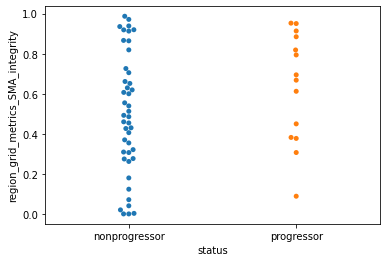

In [91]:
f = reduced.loc[include]
f['status'] = meta.loc[include]['Status']
sns.swarmplot(data=f, x='status', y='region_grid_metrics_SMA_integrity')

<AxesSubplot:xlabel='status', ylabel='boundary_cell_type_DC_cell_fraction'>

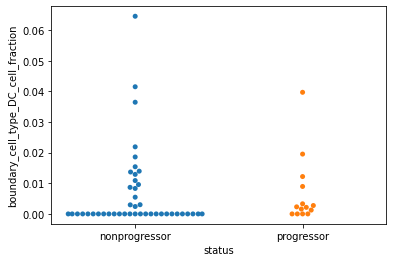

In [95]:
sns.swarmplot(data=f, x='status', y='boundary_cell_type_DC_cell_fraction', )

<AxesSubplot:xlabel='status', ylabel='boundary_cell_type_DC_cell_fraction'>

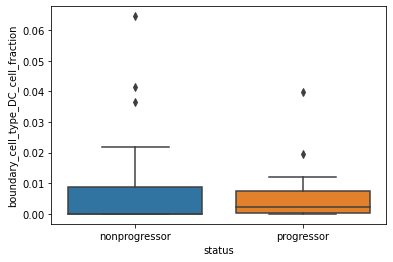

In [94]:
sns.boxplot(data=f, x='status', y='boundary_cell_type_DC_cell_fraction', )

In [99]:
include = meta[meta['LDA_Type']!='normal'].index.to_list()
X = StandardScaler().fit_transform(feats.loc[include].values)
y = np.asarray([0 if label == 'DCIS' else 1 for label in meta.loc[include]['LDA_Type']])
X.shape, y.shape

((70, 107), (70,))

In [100]:
X_df = pd.DataFrame(data=X, columns=feats.columns)
model = sm.OLS(y, X_df)
results = model.fit()

In [101]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.829
Model:                            OLS   Adj. R-squared (uncentered):            -11.000
Method:                 Least Squares   F-statistic:                            0.07005
Date:                Thu, 05 Jan 2023   Prob (F-statistic):                        1.00
Time:                        09:52:18   Log-Likelihood:                          24.126
No. Observations:                  70   AIC:                                      89.75
Df Residuals:                       1   BIC:                                      244.9
Df Model:                          69                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
boundary_cell_type_APC_cell_fraction                      0.0794      0.624      0.127      0.919      -7.845       8.004
boundary_cell_type_BCELL_cell_fraction                   -0.0242      0.440     -0.055      0.965      -5.620       5.571
boundary_cell_type_CAF_cell_fraction                      0.0185      0.476      0.039      0.975      -6.032       6.069
boundary_cell_type_CD4T_cell_fraction                    -0.1485      0.823     -0.180      0.886     -10.605      10.308
boundary_cell_type_CD8T_cell_fraction                     0.0651      0.687      0.095      0.940      -8.669       8.799
boundary_cell_type_DC_cell_fraction                      -0.0908      0.618     -0.147      0.907      -7.938       7.756
boundary_cell_type_ENDO_cell_fraction                    -0.0002      0.416     -0.001      1.000      -5.290       5.290
boundary_cell_type_FIBRO_VIMonly_cell_fraction           -0.0504      0.546     -0.092      0.941      -6.987       6.886
boundary_cell_type_IMMUNEOTHER_cell_fraction              0.0746      0.494      0.151      0.904      -6.198       6.348
boundary_cell_type_MACS_cell_fraction                    -0.0724      0.475     -0.152      0.904      -6.111       5.966
boundary_cell_type_MAST_cell_fraction                     0.0074      0.512      0.014      0.991      -6.496       6.511
boundary_cell_type_MONODC_cell_fraction                  -0.0312      0.578     -0.054      0.966      -7.378       7.316
boundary_cell_type_MONO_cell_fraction                     0.0284      0.522      0.054      0.965      -6.605       6.662
boundary_cell_type_MYOEP_cell_fraction                    0.0022      0.733      0.003      0.998      -9.307       9.312
boundary_cell_type_MYOFIBRO_cell_fraction                -0.0628      0.818     -0.077      0.951     -10.452      10.326
boundary_cell_type_NEUT_cell_fraction                    -0.0185      0.620     -0.030      0.981      -7.895       7.858
boundary_cell_type_NORMFIBRO_cell_fraction               -0.1411      0.613     -0.230      0.856      -7.932       7.650
boundary_cell_type_OTHER_cell_fraction                   -0.1244      0.833     -0.149      0.906     -10.703      10.454
boundary_cell_type_TCELL_cell_fraction                   -0.0461      0.655     -0.070      0.955      -8.364       8.271
boundary_cell_type_TUMOR_CK5_cell_fraction               -0.0532      0.535     -0.099      0.937      -6.856       6.749
boundary_cell_type_TUMOR_ECADCK_cell_fraction             0.0813      0.466      0.175      0.890      -5.835       5.998
boundary_cell_type_TUMOR_EMT_cell_fraction              

In [120]:
summary = results.summary()
result_df = summary.tables[1]
result_df = pd.DataFrame(data=result_df.data[1:], columns=result_df.data[0])
result_df = result_df.set_index('')
result_df

coef    std err          t  \
                                                                              
boundary_cell_type_APC_cell_fraction           0.0794      0.624      0.127   
boundary_cell_type_BCELL_cell_fraction        -0.0242      0.440     -0.055   
boundary_cell_type_CAF_cell_fraction           0.0185      0.476      0.039   
boundary_cell_type_CD4T_cell_fraction         -0.1485      0.823     -0.180   
boundary_cell_type_CD8T_cell_fraction          0.0651      0.687      0.095   
...                                               ...        ...        ...   
region_intensity_overlap_PanKRT_SMA           -0.0351      0.621     -0.056   
region_intensity_positive_fraction_PanKRT      0.0470      0.604      0.078   
region_intensity_positive_fraction_SMA        -0.0496      0.395     -0.126   
region_area                                    0.1015      0.686      0.148   
region_perimeter                              -0.1631      0.545     -0.299   

                                            P>|t|     [0.025     0.975]  
                                                                         
boundary_cell_type_APC_cell_fraction        0.919     -7.845      8.004  
boundary_cell_type_BCELL_cell_fraction      0.965     -5.620      5.571  
boundary_cell_type_CAF_cell_fraction        0.975     -6.032      6.069  
boundary_cell_type_CD4T_cell_fraction       0.886    -10.605     10.308  
boundary_cell_type_CD8T_cell_fraction       0.940     -8.669      8.799  
...                                           ...        ...        ...  
region_intensity_overlap_PanKRT_SMA         0.964     -7.931      7.861  
region_intensity_positive_fraction_PanKRT   0.951     -7.632      7.726  
region_intensity_positive_fraction_SMA      0.920     -5.070      4.971  
region_area                                 0.907     -8.621      8.824  
region_perimeter                            0.815     -7.090      6.763  

[107 rows x 6 columns]

In [121]:
result_df.sort_values('P>|t|')

coef    std err  \
                                                                      
region_perimeter                                 -0.1631      0.545   
region_cell_type_CAF_cell_fraction                0.1649      0.561   
boundary_perimeter                                0.0882      0.309   
myoepi_compactness                                0.1743      0.688   
myoepi_cell_type_TUMOR_LUMINAL_cell_fraction     -0.1015      0.428   
...                                                  ...        ...   
region_cell_type_DC_cell_fraction                 0.0034      0.628   
myoepi_cell_type_CD4T_cell_fraction               0.0021      0.772   
boundary_cell_type_MYOEP_cell_fraction            0.0022      0.733   
myoepi_cell_type_NEUT_cell_fraction              -0.0021      0.967   
boundary_cell_type_ENDO_cell_fraction            -0.0002      0.416   

                                                      t   P>|t|     [0.025  \
                                                                             
region_perimeter                                 -0.299   0.815     -7.090   
region_cell_type_CAF_cell_fraction                0.294   0.818     -6.965   
boundary_perimeter                                0.286   0.823     -3.834   
myoepi_compactness                                0.253   0.842     -8.570   
myoepi_cell_type_TUMOR_LUMINAL_cell_fraction     -0.237   0.852     -5.540   
...                                                 ...     ...        ...   
region_cell_type_DC_cell_fraction                 0.005   0.997     -7.971   
myoepi_cell_type_CD4T_cell_fraction               0.003   0.998     -9.810   
boundary_cell_type_MYOEP_cell_fraction            0.003   0.998     -9.307   
myoepi_cell_type_NEUT_cell_fraction              -0.002   0.999    -12.289   
boundary_cell_type_ENDO_cell_fraction            -0.001   1.000     -5.290   

                                                 0.975]  
                                                         
region_perimeter                                  6.763  
region_cell_type_CAF_cell_fraction                7.295  
boundary_perimeter                                4.010  
myoepi_compactness                                8.919  
myoepi_cell_type_TUMOR_LUMINAL_cell_fraction      5.337  
...                                                 ...  
region_cell_type_DC_cell_fraction                 7.978  
myoepi_cell_type_CD4T_cell_fraction               9.814  
boundary_cell_type_MYOEP_cell_fraction            9.312  
myoepi_cell_type_NEUT_cell_fraction              12.285  
boundary_cell_type_ENDO_cell_fraction             5.290  

[107 rows x 6 columns]

In [122]:
result_df.sort_values('coef')

coef    std err          t  \
                                                                               
myoepi_cell_type_CD4T_cell_fraction             0.0021      0.772      0.003   
boundary_cell_type_MYOEP_cell_fraction          0.0022      0.733      0.003   
region_cell_type_DC_cell_fraction               0.0034      0.628      0.005   
myoepi_perimeter                                0.0056      0.250      0.023   
boundary_cell_type_MAST_cell_fraction           0.0074      0.512      0.014   
...                                                ...        ...        ...   
region_compactness                             -0.1167      0.510     -0.229   
boundary_cell_type_OTHER_cell_fraction         -0.1244      0.833     -0.149   
boundary_cell_type_NORMFIBRO_cell_fraction     -0.1411      0.613     -0.230   
boundary_cell_type_CD4T_cell_fraction          -0.1485      0.823     -0.180   
region_perimeter                               -0.1631      0.545     -0.299   

                                             P>|t|     [0.025     0.975]  
                                                                          
myoepi_cell_type_CD4T_cell_fraction          0.998     -9.810      9.814  
boundary_cell_type_MYOEP_cell_fraction       0.998     -9.307      9.312  
region_cell_type_DC_cell_fraction            0.997     -7.971      7.978  
myoepi_perimeter                             0.986     -3.166      3.177  
boundary_cell_type_MAST_cell_fraction        0.991     -6.496      6.511  
...                                            ...        ...        ...  
region_compactness                           0.857     -6.599      6.366  
boundary_cell_type_OTHER_cell_fraction       0.906    -10.703     10.454  
boundary_cell_type_NORMFIBRO_cell_fraction   0.856     -7.932      7.650  
boundary_cell_type_CD4T_cell_fraction        0.886    -10.605     10.308  
region_perimeter                             0.815     -7.090      6.763  

[107 rows x 6 columns]

<AxesSubplot:xlabel='status', ylabel='region_perimeter'>

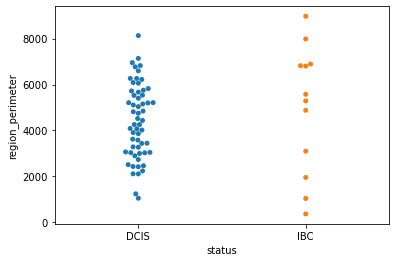

In [104]:
f = reduced.loc[include]
f['status'] = meta.loc[include]['LDA_Type']
sns.swarmplot(data=f, x='status', y='region_perimeter', )

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='status', ylabel='region_cell_type_CAF_cell_fraction'>

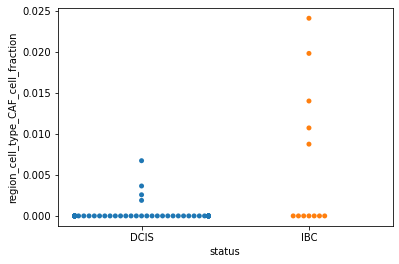

In [105]:
sns.swarmplot(data=f, x='status', y='region_cell_type_CAF_cell_fraction', )

<AxesSubplot:xlabel='status', ylabel='region_grid_metrics_SMA_integrity'>

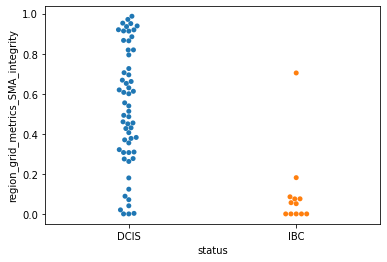

In [106]:
sns.swarmplot(data=f, x='status', y='region_grid_metrics_SMA_integrity', )

In [126]:
include = meta[meta['LDA_Type']!='normal'].index.to_list()
fts = feats[[c for c in feats.columns if 'cell_fraction' not in c]]
X = StandardScaler().fit_transform(fts.loc[include].values)
y = np.asarray([0 if label == 'DCIS' else 1 for label in meta.loc[include]['LDA_Type']])
X.shape, y.shape

((70, 38), (70,))

In [127]:
X_df = pd.DataFrame(data=X, columns=fts.columns)
model = sm.OLS(y, X_df)
results = model.fit()

In [128]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.709
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              2.894
Date:                Thu, 05 Jan 2023   Prob (F-statistic):                    0.000983
Time:                        10:05:42   Log-Likelihood:                          5.6117
No. Observations:                  70   AIC:                                      52.78
Df Residuals:                      38   BIC:                                      124.7
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
boundary_compactness                                     -0.0722      0.312     -0.232      0.818      -0.703       0.559
boundary_eccentricity                                    -0.0871      0.128     -0.682      0.499      -0.346       0.171
boundary_extent                                          -0.1797      0.232     -0.773      0.444      -0.650       0.291
boundary_intensity_overlap_PanKRT_SMA                    -0.8263      0.447     -1.848      0.072      -1.731       0.079
boundary_intensity_positive_fraction_PanKRT              -0.1053      0.238     -0.443      0.660      -0.587       0.376
boundary_intensity_positive_fraction_SMA                  0.0375      0.106      0.356      0.724      -0.176       0.251
boundary_area                                            -0.0893      0.313     -0.286      0.777      -0.722       0.544
boundary_perimeter                                       -0.4757      0.983     -0.484      0.631      -2.465       1.514
myoepi_compactness                                        0.1997      0.358      0.557      0.581      -0.526       0.925
myoepi_eccentricity                                       0.0676      0.108      0.628      0.534      -0.150       0.285
myoepi_extent                                             0.3021      0.346      0.872      0.389      -0.399       1.003
myoepi_intensity_overlap_PanKRT_SMA                       0.8561      0.446      1.920      0.062      -0.047       1.759
myoepi_intensity_positive_fraction_PanKRT                 0.0245      0.141      0.173      0.864      -0.262       0.311
myoepi_intensity_positive_fraction_SMA                   -0.1065      0.220     -0.484      0.631      -0.552       0.339
myoepi_area                                              -0.9392      1.362     -0.690      0.495      -3.696       1.818
myoepi_perimeter                                          1.7878      1.898      0.942      0.352      -2.055       5.631
region_grid_metrics_SMA_fraction_positive                -0.0196      0.085     -0.231      0.818      -0.191       0.152
region_grid_metrics_SMA_integrity                        -0.0287      0.083     -0.345      0.732      -0.198       0.140
region_grid_metrics_SMA_mean_intensity                   -0.0850      0.157     -0.540      0.592      -0.403       0.233
region_grid_metrics_SMA_mean_thickness                    0.0993      0.153      0.650      0.520      -0.210       0.408
region_grid_metrics_SMA_mean_thickness_nonbreaks          0.0102      0.092      0.111      0.912      -0.176       0.197
region_grid_metrics_SMA_num_grids                       

In [135]:
summary = results.summary()
result_df = summary.tables[1]
result_df = pd.DataFrame(data=result_df.data[1:], columns=result_df.data[0])
result_df = result_df.set_index('')
result_df = pd.DataFrame(data=result_df.values.astype(float), columns=result_df.columns, index=result_df.index)
result_df

coef  std err      t  \
                                                                             
boundary_compactness                               -0.0722    0.312 -0.232   
boundary_eccentricity                              -0.0871    0.128 -0.682   
boundary_extent                                    -0.1797    0.232 -0.773   
boundary_intensity_overlap_PanKRT_SMA              -0.8263    0.447 -1.848   
boundary_intensity_positive_fraction_PanKRT        -0.1053    0.238 -0.443   
boundary_intensity_positive_fraction_SMA            0.0375    0.106  0.356   
boundary_area                                      -0.0893    0.313 -0.286   
boundary_perimeter                                 -0.4757    0.983 -0.484   
myoepi_compactness                                  0.1997    0.358  0.557   
myoepi_eccentricity                                 0.0676    0.108  0.628   
myoepi_extent                                       0.3021    0.346  0.872   
myoepi_intensity_overlap_PanKRT_SMA                 0.8561    0.446  1.920   
myoepi_intensity_positive_fraction_PanKRT           0.0245    0.141  0.173   
myoepi_intensity_positive_fraction_SMA             -0.1065    0.220 -0.484   
myoepi_area                                        -0.9392    1.362 -0.690   
myoepi_perimeter                                    1.7878    1.898  0.942   
region_grid_metrics_SMA_fraction_positive          -0.0196    0.085 -0.231   
region_grid_metrics_SMA_integrity                  -0.0287    0.083 -0.345   
region_grid_metrics_SMA_mean_intensity             -0.0850    0.157 -0.540   
region_grid_metrics_SMA_mean_thickness              0.0993    0.153  0.650   
region_grid_metrics_SMA_mean_thickness_nonbreaks    0.0102    0.092  0.111   
region_grid_metrics_SMA_num_grids                  -0.0362    1.331 -0.027   
region_grid_metrics_SMA_num_pieces                  0.0300    0.042  0.716   
region_grid_metrics_SMA_total_area                 -0.0995    1.356 -0.073   
region_grid_metrics_combined_fraction_positive     -0.0196    0.085 -0.231   
region_grid_metrics_combined_integrity             -0.0287    0.083 -0.345   
region_grid_metrics_combined_mean_thickness         0.0993    0.153  0.650   
region_grid_metrics_combined_mean_thickness_non...  0.0102    0.092  0.111   
region_grid_metrics_combined_num_pieces             0.0300    0.042  0.716   
region_grid_metrics_combined_overlap_fraction      -0.0196    0.085 -0.231   
region_compactness                                 -0.1797    0.120 -1.497   
region_eccentricity                                -0.0603    0.066 -0.914   
region_extent                                       0.0493    0.108  0.455   
region_intensity_overlap_PanKRT_SMA                -0.0155    0.151 -0.103   
region_intensity_positive_fraction_PanKRT           0.0172    0.079  0.217   
region_intensity_positive_fraction_SMA              0.0280    0.145  0.193   
region_area                                         0.1302    0.164  0.795   
region_perimeter                                   -0.2923    0.324 -0.901   

                                                    P>|t|  [0.025  0.975]  
                                                                           
boundary_compactness                                0.818  -0.703   0.559  
boundary_eccentricity                               0.499  -0.346   0.171  
boundary_extent                                     0.444  -0.650   0.291  
boundary_intensity_overlap_PanKRT_SMA               0.072  -1.731   0.079  
boundary_intensity_positive_fraction_PanKRT         0.660  -0.587   0.376  
boundary_intensity_positive_fraction_SMA            0.724  -0.176   0.251  
boundary_area                                       0.777  -0.722   0.544  
boundary_perimeter                                  0.631  -2.465   1.514  
myoepi_compactness                                  0.581  -0.526   0.925  
myoepi_eccentricity                                 0.534  -0.150   0.285  
myoepi_extent        

In [136]:
result_df.sort_values('coef')

coef  std err      t  \
                                                                             
myoepi_area                                        -0.9392    1.362 -0.690   
boundary_intensity_overlap_PanKRT_SMA              -0.8263    0.447 -1.848   
boundary_perimeter                                 -0.4757    0.983 -0.484   
region_perimeter                                   -0.2923    0.324 -0.901   
boundary_extent                                    -0.1797    0.232 -0.773   
region_compactness                                 -0.1797    0.120 -1.497   
myoepi_intensity_positive_fraction_SMA             -0.1065    0.220 -0.484   
boundary_intensity_positive_fraction_PanKRT        -0.1053    0.238 -0.443   
region_grid_metrics_SMA_total_area                 -0.0995    1.356 -0.073   
boundary_area                                      -0.0893    0.313 -0.286   
boundary_eccentricity                              -0.0871    0.128 -0.682   
region_grid_metrics_SMA_mean_intensity             -0.0850    0.157 -0.540   
boundary_compactness                               -0.0722    0.312 -0.232   
region_eccentricity                                -0.0603    0.066 -0.914   
region_grid_metrics_SMA_num_grids                  -0.0362    1.331 -0.027   
region_grid_metrics_combined_integrity             -0.0287    0.083 -0.345   
region_grid_metrics_SMA_integrity                  -0.0287    0.083 -0.345   
region_grid_metrics_combined_overlap_fraction      -0.0196    0.085 -0.231   
region_grid_metrics_combined_fraction_positive     -0.0196    0.085 -0.231   
region_grid_metrics_SMA_fraction_positive          -0.0196    0.085 -0.231   
region_intensity_overlap_PanKRT_SMA                -0.0155    0.151 -0.103   
region_grid_metrics_SMA_mean_thickness_nonbreaks    0.0102    0.092  0.111   
region_grid_metrics_combined_mean_thickness_non...  0.0102    0.092  0.111   
region_intensity_positive_fraction_PanKRT           0.0172    0.079  0.217   
myoepi_intensity_positive_fraction_PanKRT           0.0245    0.141  0.173   
region_intensity_positive_fraction_SMA              0.0280    0.145  0.193   
region_grid_metrics_combined_num_pieces             0.0300    0.042  0.716   
region_grid_metrics_SMA_num_pieces                  0.0300    0.042  0.716   
boundary_intensity_positive_fraction_SMA            0.0375    0.106  0.356   
region_extent                                       0.0493    0.108  0.455   
myoepi_eccentricity                                 0.0676    0.108  0.628   
region_grid_metrics_combined_mean_thickness         0.0993    0.153  0.650   
region_grid_metrics_SMA_mean_thickness              0.0993    0.153  0.650   
region_area                                         0.1302    0.164  0.795   
myoepi_compactness                                  0.1997    0.358  0.557   
myoepi_extent                                       0.3021    0.346  0.872   
myoepi_intensity_overlap_PanKRT_SMA                 0.8561    0.446  1.920   
myoepi_perimeter                                    1.7878    1.898  0.942   

                                                    P>|t|  [0.025  0.975]  
                                                                           
myoepi_area                                         0.495  -3.696   1.818  
boundary_intensity_overlap_PanKRT_SMA               0.072  -1.731   0.079  
boundary_perimeter                                  0.631  -2.465   1.514  
region_perimeter                                    0.373  -0.949   0.364  
boundary_extent                                     0.444  -0.650   0.291  
region_compactness                                  0.143  -0.423   0.063  
myoepi_intensity_positive_fraction_SMA              0.631  -0.552   0.339  
boundary_intensity_positive_fraction_PanKRT         0.660  -0.587   0.376  
region_grid_metrics_SMA_total_area                  0.942  -2.844   2.645  
boundary_area                                       0.777  -0.722   0.544  
boundary_eccentricity

In [137]:
result_df.sort_values('P>|t|')

coef  std err      t  \
                                                                             
myoepi_intensity_overlap_PanKRT_SMA                 0.8561    0.446  1.920   
boundary_intensity_overlap_PanKRT_SMA              -0.8263    0.447 -1.848   
region_compactness                                 -0.1797    0.120 -1.497   
myoepi_perimeter                                    1.7878    1.898  0.942   
region_eccentricity                                -0.0603    0.066 -0.914   
region_perimeter                                   -0.2923    0.324 -0.901   
myoepi_extent                                       0.3021    0.346  0.872   
region_area                                         0.1302    0.164  0.795   
boundary_extent                                    -0.1797    0.232 -0.773   
region_grid_metrics_combined_num_pieces             0.0300    0.042  0.716   
region_grid_metrics_SMA_num_pieces                  0.0300    0.042  0.716   
myoepi_area                                        -0.9392    1.362 -0.690   
boundary_eccentricity                              -0.0871    0.128 -0.682   
region_grid_metrics_SMA_mean_thickness              0.0993    0.153  0.650   
region_grid_metrics_combined_mean_thickness         0.0993    0.153  0.650   
myoepi_eccentricity                                 0.0676    0.108  0.628   
myoepi_compactness                                  0.1997    0.358  0.557   
region_grid_metrics_SMA_mean_intensity             -0.0850    0.157 -0.540   
myoepi_intensity_positive_fraction_SMA             -0.1065    0.220 -0.484   
boundary_perimeter                                 -0.4757    0.983 -0.484   
region_extent                                       0.0493    0.108  0.455   
boundary_intensity_positive_fraction_PanKRT        -0.1053    0.238 -0.443   
boundary_intensity_positive_fraction_SMA            0.0375    0.106  0.356   
region_grid_metrics_combined_integrity             -0.0287    0.083 -0.345   
region_grid_metrics_SMA_integrity                  -0.0287    0.083 -0.345   
boundary_area                                      -0.0893    0.313 -0.286   
region_grid_metrics_SMA_fraction_positive          -0.0196    0.085 -0.231   
region_grid_metrics_combined_overlap_fraction      -0.0196    0.085 -0.231   
boundary_compactness                               -0.0722    0.312 -0.232   
region_grid_metrics_combined_fraction_positive     -0.0196    0.085 -0.231   
region_intensity_positive_fraction_PanKRT           0.0172    0.079  0.217   
region_intensity_positive_fraction_SMA              0.0280    0.145  0.193   
myoepi_intensity_positive_fraction_PanKRT           0.0245    0.141  0.173   
region_grid_metrics_SMA_mean_thickness_nonbreaks    0.0102    0.092  0.111   
region_grid_metrics_combined_mean_thickness_non...  0.0102    0.092  0.111   
region_intensity_overlap_PanKRT_SMA                -0.0155    0.151 -0.103   
region_grid_metrics_SMA_total_area                 -0.0995    1.356 -0.073   
region_grid_metrics_SMA_num_grids                  -0.0362    1.331 -0.027   

                                                    P>|t|  [0.025  0.975]  
                                                                           
myoepi_intensity_overlap_PanKRT_SMA                 0.062  -0.047   1.759  
boundary_intensity_overlap_PanKRT_SMA               0.072  -1.731   0.079  
region_compactness                                  0.143  -0.423   0.063  
myoepi_perimeter                                    0.352  -2.055   5.631  
region_eccentricity                                 0.367  -0.194   0.073  
region_perimeter                                    0.373  -0.949   0.364  
myoepi_extent                                       0.389  -0.399   1.003  
region_area                                         0.431  -0.201   0.462  
boundary_extent                                     0.444  -0.650   0.291  
region_grid_metrics_combined_num_pieces             0.478  -0.055   0.115  
region_grid_metrics_S

<AxesSubplot:xlabel='status', ylabel='myoepi_intensity_overlap_PanKRT_SMA'>

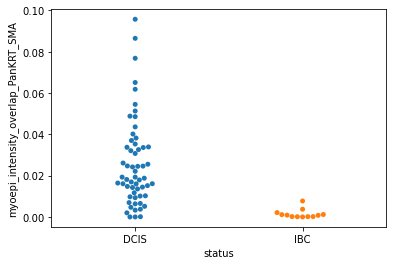

In [138]:
f = reduced.loc[include]
f['status'] = meta.loc[include]['LDA_Type']
sns.swarmplot(data=f, x='status', y='myoepi_intensity_overlap_PanKRT_SMA', )

<AxesSubplot:xlabel='status', ylabel='boundary_intensity_overlap_PanKRT_SMA'>

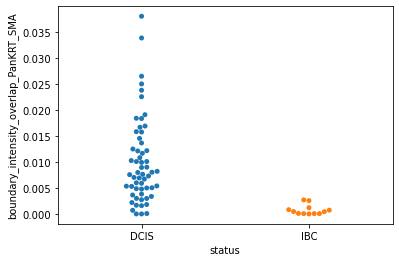

In [139]:
sns.swarmplot(data=f, x='status', y='boundary_intensity_overlap_PanKRT_SMA', )

###### xgboost

In [13]:
import xgboost
import shap
from sklearn.preprocessing import StandardScaler

# # train an XGBoost model
# X, y = shap.datasets.boston()
# model = xgboost.XGBRegressor().fit(X, y)

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.Explainer(model)
# shap_values = explainer(X)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

In [26]:
feats = reduced[[c for c in reduced.columns if 'expanded' not in c]]
feats = reduced[[c for c in feats.columns if 'cell_fraction' not in c]]
feats

boundary_compactness  boundary_eccentricity  boundary_extent  \
sample                                                                    
Point2203              0.277972               0.965336         0.455393   
Point2204              0.402218               0.758392         0.641015   
Point2206              0.189497               0.850813         0.365237   
Point2302              0.282516               0.970342         0.270690   
Point2303              0.202730               0.640258         0.440927   
...                         ...                    ...              ...   
Point6201              0.196555               0.788382         0.479038   
Point6202              0.160422               0.778136         0.326770   
Point6203              0.143987               0.657321         0.536223   
Point6204              0.410903               0.779039         0.522658   
Point6206              0.325114               0.946626         0.398894   

           boundary_intensity_overlap_PanKRT_SMA  \
sample                                             
Point2203                               0.026516   
Point2204                               0.002990   
Point2206                               0.001808   
Point2302                               0.005998   
Point2303                               0.038071   
...                                          ...   
Point6201                               0.010276   
Point6202                               0.001673   
Point6203                               0.007031   
Point6204                               0.015843   
Point6206                               0.016691   

           boundary_intensity_positive_fraction_PanKRT  \
sample                                                   
Point2203                                     0.099580   
Point2204                                     0.072686   
Point2206                                     0.080982   
Point2302                                     0.090414   
Point2303                                     0.104816   
...                                                ...   
Point6201                                     0.139685   
Point6202                                     0.099858   
Point6203                                     0.106647   
Point6204                                     0.102178   
Point6206                                     0.099445   

           boundary_intensity_positive_fraction_SMA  boundary_area  \
sample                                                               
Point2203                                  0.084875         176270   
Point2204                                  0.019496         294678   
Point2206                                  0.050722         434725   
Point2302                                  0.045631         180558   
Point2303                                  0.089877         415355   
...                                             ...            ...   
Point6201                                  0.032262         714585   
Point6202                                  0.033596         346713   
Point6203                                  0.063803         409058   
Point6204                                  0.094274         559688   
Point6206                                  0.065106         267335   

           boundary_perimeter  myoepi_compactness  myoepi_eccentricity  ...  \
sample                                                                  ...   
Point2203         2822.885569            0.108389             0.974883  ...   
Point2204         5106.384269            0.208029             0.684528  ...   
Point2206         7591.922866            0.079803             0.819741  ...   
Point2302         2833.946535            0.115744             0.976709  ...   
Point2303         7255.639462            0.103002             0.607301  ...   
...                       ...                 ...                  ...  ...   
Point6201        20070.661279            0.137661           

In [37]:
include = meta[meta['LDA_Type']=='DCIS'].index.to_list()
include = np.random.permutation(include)
X = StandardScaler().fit_transform(feats.loc[include].values)
y = np.asarray([0 if label == 'nonprogressor' else 1 for label in meta.loc[include]['Status']])
X.shape, y.shape

((58, 38), (58,))

In [38]:
X_df = pd.DataFrame(data=X, columns=feats.columns)

In [39]:
model = xgboost.XGBClassifier().fit(X_df, y)
explainer = shap.Explainer(model)
shap_values = explainer(X_df)

[13:59:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [40]:
shap.initjs()

In [41]:
shap.plots.force(shap_values[0])

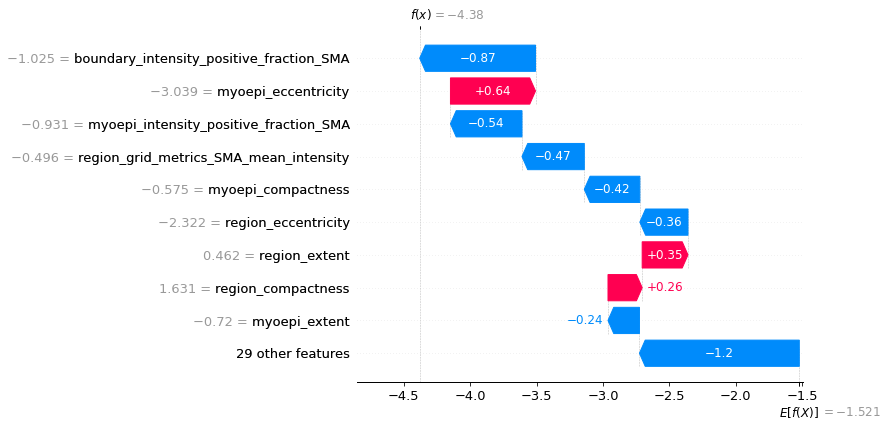

In [42]:
shap.waterfall_plot(shap_values[0])

In [43]:
shap.plots.force(shap_values)

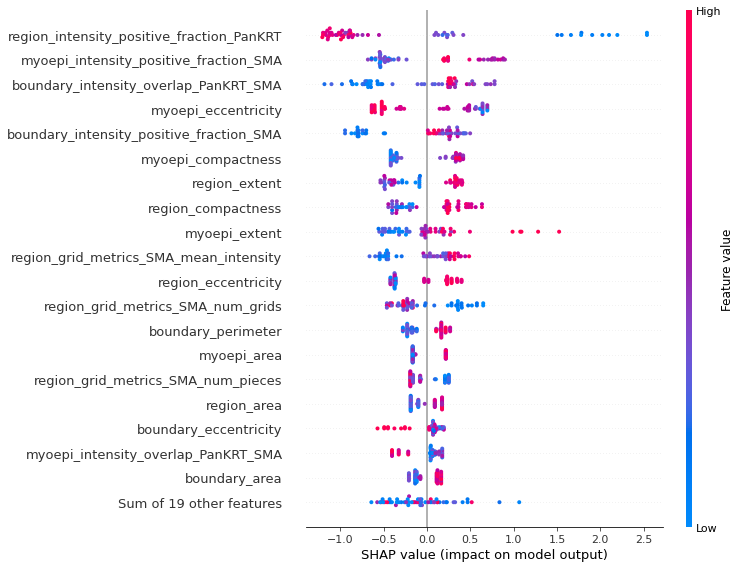

In [44]:
shap.plots.beeswarm(shap_values, max_display=20)

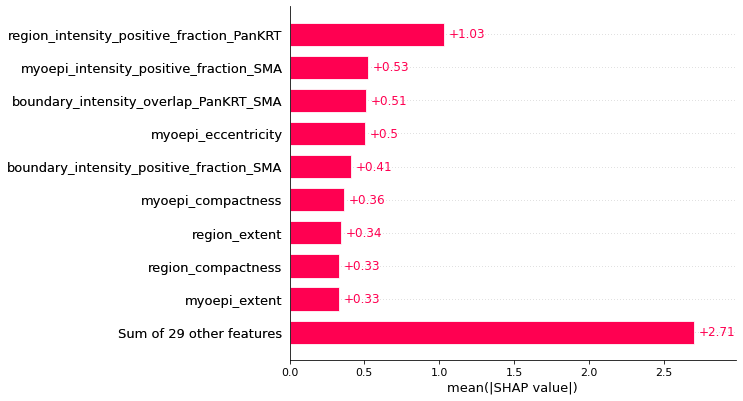

In [45]:
shap.plots.bar(shap_values)

###### t test

In [12]:
from statsmodels.stats.weightstats import ttest_ind
from collections import Counter
Counter(meta['LDA_Type']).most_common()

[('DCIS', 58), ('IBC', 12), ('normal', 9)]

In [13]:
feats = reduced[[c for c in reduced.columns if 'expanded' not in c]].copy()
include = meta.index.to_list()
feats = feats.loc[include]
labels = meta.loc[include]['LDA_Type']

In [14]:
from scipy.stats import wilcoxon

In [15]:
cats = sorted(set(labels))
grid = np.meshgrid(cats, cats)
tups = [tuple(sorted([x, y])) for x, y in zip(grid[0].flatten(), grid[1].flatten()) if x!=y]
combos = sorted(set(tups))

data = []
for c in feats.columns:
    for x, y in combos:
        stat, p_value, _ = ttest_ind(feats[c][labels==x], feats[c][labels==y])
#         stat, p_value = wilcoxon(feats[c][labels==x], feats[c][labels==y])
        data.append([c, x, y, stat, p_value])
df = pd.DataFrame(data=data, columns=['feature', 'class_1', 'class_2', 'statistic', 'p-value'])
df

feature class_1 class_2  statistic  \
0      boundary_cell_type_APC_cell_fraction    DCIS     IBC  -0.243107   
1      boundary_cell_type_APC_cell_fraction    DCIS  normal   1.286490   
2      boundary_cell_type_APC_cell_fraction     IBC  normal   1.822573   
3    boundary_cell_type_BCELL_cell_fraction    DCIS     IBC   0.757427   
4    boundary_cell_type_BCELL_cell_fraction    DCIS  normal  -0.700309   
..                                      ...     ...     ...        ...   
520                             region_area    DCIS  normal   3.861326   
521                             region_area     IBC  normal   1.944252   
522                        region_perimeter    DCIS     IBC  -2.185762   
523                        region_perimeter    DCIS  normal   0.401912   
524                        region_perimeter     IBC  normal   1.551295   

      p-value  
0    0.808654  
1    0.202836  
2    0.084146  
3    0.451411  
4    0.486233  
..        ...  
520  0.000262  
521  0.066822  
522  0.032280  
523  0.689068  
524  0.137329  

[525 rows x 5 columns]

In [16]:
f = df[[False if 'cell_fraction' in feat else True for feat in df['feature']]]
f

feature class_1 class_2  statistic   p-value
69    boundary_compactness    DCIS     IBC  -1.058632  0.293513
70    boundary_compactness    DCIS  normal  -1.764952  0.082269
71    boundary_compactness     IBC  normal  -0.336610  0.740100
72   boundary_eccentricity    DCIS     IBC   3.517392  0.000781
73   boundary_eccentricity    DCIS  normal   2.100812  0.039540
..                     ...     ...     ...        ...       ...
520            region_area    DCIS  normal   3.861326  0.000262
521            region_area     IBC  normal   1.944252  0.066822
522       region_perimeter    DCIS     IBC  -2.185762  0.032280
523       region_perimeter    DCIS  normal   0.401912  0.689068
524       region_perimeter     IBC  normal   1.551295  0.137329

[318 rows x 5 columns]

In [17]:
f.sort_values('p-value').iloc[:20]

feature class_1 class_2  statistic  \
359          region_grid_metrics_SMA_integrity     IBC  normal -12.161292   
517     region_intensity_positive_fraction_SMA    DCIS  normal  -6.539318   
499          region_intensity_overlap_ECAD_SMA    DCIS  normal  -6.299818   
251     myoepi_intensity_positive_fraction_SMA     IBC  normal  -8.448605   
205                              myoepi_extent    DCIS  normal  -5.747390   
365     region_grid_metrics_SMA_mean_thickness     IBC  normal  -7.031249   
356  region_grid_metrics_SMA_fraction_positive     IBC  normal  -6.938632   
357          region_grid_metrics_SMA_integrity    DCIS     IBC   5.203005   
472                              region_extent    DCIS  normal   5.168005   
362     region_grid_metrics_SMA_mean_intensity     IBC  normal  -6.524685   
204                              myoepi_extent    DCIS     IBC  -4.864112   
232          myoepi_intensity_overlap_ECAD_SMA    DCIS  normal  -4.878970   
502        region_intensity_overlap_PanKRT_SMA    DCIS  normal  -4.747221   
246  myoepi_intensity_positive_fraction_PanKRT    DCIS     IBC   4.712281   
103        boundary_intensity_overlap_ECAD_SMA    DCIS  normal  -4.728970   
249     myoepi_intensity_positive_fraction_SMA    DCIS     IBC   4.676898   
104        boundary_intensity_overlap_ECAD_SMA     IBC  normal  -5.746813   
107      boundary_intensity_overlap_PanKRT_SMA     IBC  normal  -5.693942   
493           region_intensity_overlap_CK7_SMA    DCIS  normal  -4.634041   
236        myoepi_intensity_overlap_PanKRT_SMA     IBC  normal  -5.307161   

          p-value  
359  2.067151e-10  
517  1.121021e-08  
499  2.933976e-08  
251  7.383549e-08  
205  2.619570e-07  
365  1.078032e-06  
356  1.296566e-06  
357  1.968209e-06  
472  2.446353e-06  
362  3.000596e-06  
204  7.130136e-06  
232  7.228579e-06  
502  1.174918e-05  
246  1.254669e-05  
103  1.256156e-05  
249  1.429690e-05  
104  1.543020e-05  
107  1.729409e-05  
493  1.775478e-05  
236  4.021898e-05

In [19]:
import seaborn as sns

<AxesSubplot:xlabel='LDA_Type', ylabel='region_grid_metrics_SMA_integrity'>

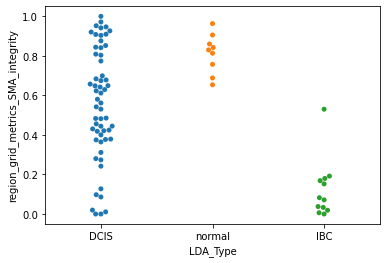

In [20]:
sns.swarmplot(data=feats, x=labels, y='region_grid_metrics_SMA_integrity')

<AxesSubplot:xlabel='LDA_Type', ylabel='myoepi_intensity_overlap_ECAD_SMA'>

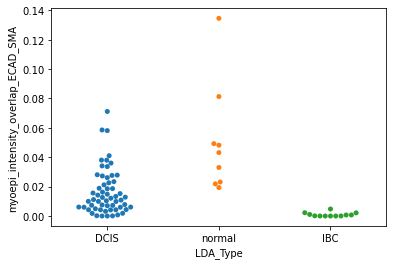

In [24]:
sns.swarmplot(data=feats, x=labels, y='myoepi_intensity_overlap_ECAD_SMA')

<AxesSubplot:xlabel='LDA_Type', ylabel='region_grid_metrics_SMA_integrity'>

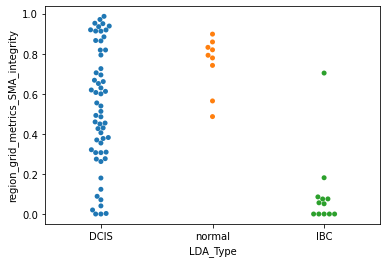

In [110]:
sns.swarmplot(data=feats, x=labels, y='region_grid_metrics_SMA_integrity')

<AxesSubplot:xlabel='LDA_Type', ylabel='myoepi_intensity_overlap_PanKRT_SMA'>

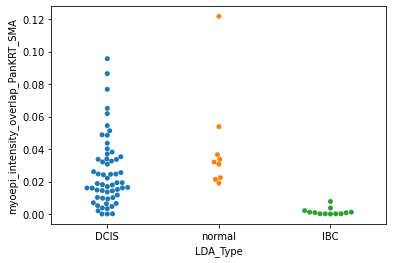

In [111]:
sns.swarmplot(data=feats, x=labels, y='myoepi_intensity_overlap_PanKRT_SMA')

<AxesSubplot:xlabel='LDA_Type', ylabel='region_area'>

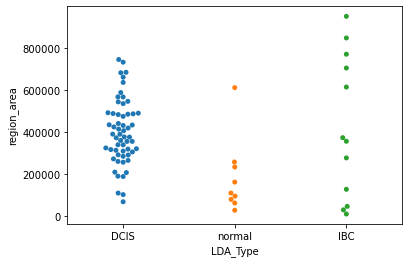

In [25]:
sns.swarmplot(data=feats, x=labels, y='region_area')

In [26]:
df = feats.copy()
df['status'] = meta.loc[df.index]['LDA_Type']
df = df.groupby('status').mean()
df

boundary_cell_type_APC_cell_fraction  \
status                                         
DCIS                                0.056363   
IBC                                 0.062113   
normal                              0.022215   

        boundary_cell_type_BCELL_cell_fraction  \
status                                           
DCIS                                  0.007141   
IBC                                   0.001815   
normal                                0.013555   

        boundary_cell_type_CAF_cell_fraction  \
status                                         
DCIS                                0.042858   
IBC                                 0.061776   
normal                              0.004714   

        boundary_cell_type_CD4T_cell_fraction  \
status                                          
DCIS                                 0.030953   
IBC                                  0.008715   
normal                               0.013397   

        boundary_cell_type_CD8T_cell_fraction  \
status                                          
DCIS                                 0.015327   
IBC                                  0.019771   
normal                               0.011659   

        boundary_cell_type_DC_cell_fraction  \
status                                        
DCIS                               0.007681   
IBC                                0.010401   
normal                             0.001014   

        boundary_cell_type_ENDO_cell_fraction  \
status                                          
DCIS                                 0.071173   
IBC                                  0.034489   
normal                               0.033598   

        boundary_cell_type_FIBRO_VIMonly_cell_fraction  \
status                                                   
DCIS                                          0.101480   
IBC                                           0.043751   
normal                                        0.151278   

        boundary_cell_type_IMMUNEOTHER_cell_fraction  \
status                                                 
DCIS                                        0.020027   
IBC                                         0.021362   
normal                                      0.015812   

        boundary_cell_type_MACS_cell_fraction  ...  \
status                                         ...   
DCIS                                 0.015434  ...   
IBC                                  0.037857  ...   
normal                               0.004541  ...   

        region_intensity_overlap_ECAD_PanKRT  \
status                                         
DCIS                                0.181855   
IBC                                 0.105315   
normal                              0.194298   

        region_intensity_overlap_ECAD_SMA  \
status                                      
DCIS                             0.004122   
IBC                              0.001119   
normal                           0.031368   

        region_intensity_overlap_PanKRT_SMA  \
status                                        
DCIS                               0.007017   
IBC                                0.003206   
normal                             0.043159   

        region_intensity_positive_fraction_CK5  \
status                                           
DCIS                                  0.020666   
IBC                                   0.081958   
normal                                0.023830   

        region_intensity_positive_fraction_CK7  \
status                                           
DCIS                                  0.230971   
IBC                                   0.189028   
normal                                0.345915   

        region_intensity_positive_fraction_ECAD  \
status                                            
DCIS                                   0.216168   
IBC                                    0.138755   
normal                                 0.226522  

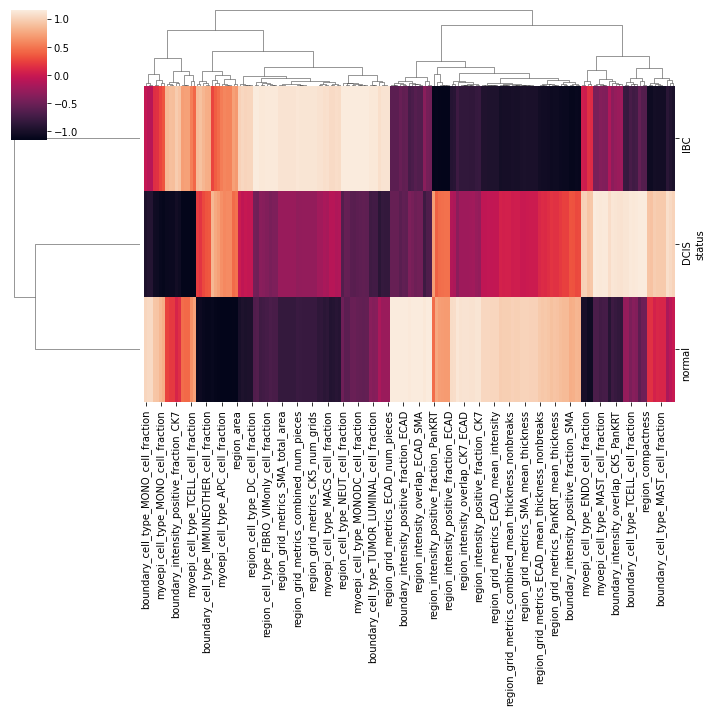

In [27]:
sns.clustermap(df, z_score=True)

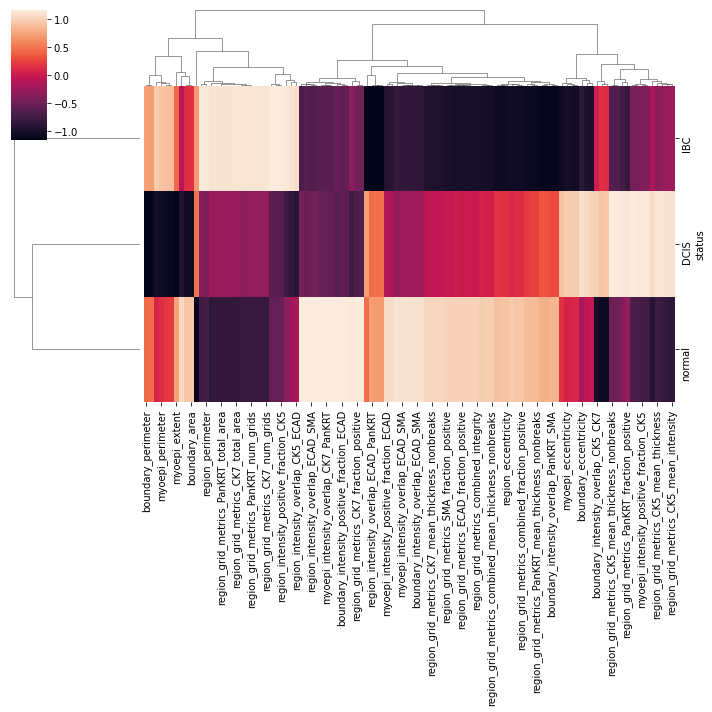

In [28]:
sns.clustermap(df[[c for c in df.columns if 'cell_fraction' not in c]], z_score=True)

In [29]:
Counter(meta['Status']).most_common()

[('nonprogressor', 44),
 ('progressor', 14),
 ('IBC_recurrence', 12),
 ('normal', 9)]

In [30]:
feats = reduced[[c for c in reduced.columns if 'expanded' not in c]].copy()
include = meta[meta['LDA_Type']=='DCIS'].index.to_list()
feats = feats.loc[include]
status = np.asarray([False if label == 'nonprogressor' else True
                     for label in meta.loc[include]['Status']])
feats

boundary_cell_type_APC_cell_fraction  \
sample                                            
Point2203                              0.011111   
Point2204                              0.050723   
Point2206                              0.108232   
Point2302                              0.010101   
Point2303                              0.023077   
Point2304                              0.028261   
Point2306                              0.134265   
Point2309                              0.019139   
Point2310                              0.000000   
Point2311                              0.014531   
Point2312                              0.012992   
Point2313                              0.000000   
Point2318                              0.098901   
Point2319                              0.209302   
Point2320                              0.079879   
Point2321                              0.016180   
Point2322                              0.134923   
Point2325                              0.049502   
Point2326                              0.043185   
Point2327                              0.032504   
Point2328                              0.009704   
Point2331                              0.015707   
Point3102                              0.081365   
Point3104                              0.011765   
Point3105                              0.031735   
Point3107                              0.014181   
Point3108                              0.062945   
Point3110                              0.083534   
Point3111                              0.027920   
Point3112                              0.018868   
Point3114                              0.017544   
Point3115                              0.000000   
Point3117                              0.056338   
Point3119                              0.130255   
Point3120                              0.000000   
Point3121                              0.120078   
Point3123                              0.058559   
Point3125                              0.015220   
Point3128                              0.009684   
Point3129                              0.038545   
Point4410                              0.008624   
Point4411                              0.004692   
Point5202                              0.495575   
Point5302                              0.026786   
Point5303                              0.029066   
Point5304                              0.015338   
Point5305                              0.057867   
Point5306                              0.158647   
Point5308                              0.205056   
Point5309                              0.007599   
Point5310                              0.076579   
Point6102                              0.059780   
Point6103                              0.030501   
Point6201                              0.005646   
Point6202                              0.035611   
Point6203                              0.007120   
Point6204                              0.026108   
Point6206                              0.137683   

           boundary_cell_type_BCELL_cell_fraction  \
sample                                              
Point2203                                0.000000   
Point2204                                0.000000   
Point2206                                0.000000   
Point2302                                0.000000   
Point2303                                0.002564   
Point2304                                0.012778   
Point2306                                0.000000   
Point2309                                0.000000   
Point2310                                0.000000   
Point2311                                0.000000   
Point2312                                0.004783   
Point2313                                0.000000   
Point2318                                0.000000   
Point2319                                0.015504   
Point2320                                0.000000   
Point2321                                0.000000

In [31]:
Counter(meta.loc[include]['Status']).most_common()

[('nonprogressor', 44), ('progressor', 14)]

In [32]:
xs = feats['region_grid_metrics_SMA_integrity']
stat, p_val, _ = ttest_ind(xs[status], xs[~status])
stat, p_val

(2.0433706384672097, 0.04573151885528907)

In [33]:
features = feats.columns
scores = [ttest_ind(feats[c][status], feats[c][~status]) for c in feats.columns]

In [34]:
data = []
for (stat, p, _), c in zip(scores, feats.columns):
    data.append([c, stat, p])
df = pd.DataFrame(data=data, columns=['feature', 'statistic', 'p-value'])
df

feature  statistic   p-value
0         boundary_cell_type_APC_cell_fraction  -0.573928  0.568315
1       boundary_cell_type_BCELL_cell_fraction   1.515118  0.135367
2         boundary_cell_type_CAF_cell_fraction  -1.001821  0.320739
3        boundary_cell_type_CD4T_cell_fraction   0.368704  0.713738
4        boundary_cell_type_CD8T_cell_fraction   0.491026  0.625327
..                                         ...        ...       ...
170    region_intensity_positive_fraction_ECAD   0.872615  0.386599
171  region_intensity_positive_fraction_PanKRT  -1.106835  0.273097
172     region_intensity_positive_fraction_SMA  -0.343228  0.732712
173                                region_area   0.486845  0.628268
174                           region_perimeter   2.326793  0.023619

[175 rows x 3 columns]

In [35]:
df.sort_values('p-value')

feature  statistic   p-value
106  region_grid_metrics_ECAD_mean_thickness_nonbreaks   4.187979  0.000101
105            region_grid_metrics_ECAD_mean_thickness   3.503468  0.000911
102         region_grid_metrics_ECAD_fraction_positive   3.342659  0.001484
104            region_grid_metrics_ECAD_mean_intensity   3.227745  0.002087
81             myoepi_intensity_positive_fraction_ECAD   3.204571  0.002234
..                                                 ...        ...       ...
16          boundary_cell_type_NORMFIBRO_cell_fraction  -0.081948  0.934981
27                 boundary_intensity_overlap_CK5_ECAD  -0.068379  0.945728
37            boundary_intensity_positive_fraction_CK7  -0.039955  0.968271
32                  boundary_intensity_overlap_CK7_SMA   0.032791  0.973958
8         boundary_cell_type_IMMUNEOTHER_cell_fraction   0.012799  0.989834

[175 rows x 3 columns]

In [36]:
df.sort_values('p-value').iloc[:20]

feature  statistic   p-value
106  region_grid_metrics_ECAD_mean_thickness_nonbreaks   4.187979  0.000101
105            region_grid_metrics_ECAD_mean_thickness   3.503468  0.000911
102         region_grid_metrics_ECAD_fraction_positive   3.342659  0.001484
104            region_grid_metrics_ECAD_mean_intensity   3.227745  0.002087
81             myoepi_intensity_positive_fraction_ECAD   3.204571  0.002234
38           boundary_intensity_positive_fraction_ECAD   3.119320  0.002863
34                 boundary_intensity_overlap_ECAD_SMA   3.058644  0.003407
42                                  boundary_perimeter   2.607173  0.011679
77                   myoepi_intensity_overlap_ECAD_SMA   2.475818  0.016343
85                                    myoepi_perimeter   2.425020  0.018558
84                                         myoepi_area   2.404500  0.019527
174                                   region_perimeter   2.326793  0.023619
9                boundary_cell_type_MACS_cell_fraction   2.274749  0.026771
120             region_grid_metrics_SMA_mean_intensity   2.198520  0.032061
68                                       myoepi_extent   2.180435  0.033443
33              boundary_intensity_overlap_ECAD_PanKRT   2.169709  0.034288
156                                region_eccentricity   2.055939  0.044461
119                  region_grid_metrics_SMA_integrity   2.043371  0.045732
103                 region_grid_metrics_ECAD_integrity   2.033057  0.046797
76                myoepi_intensity_overlap_ECAD_PanKRT   1.982805  0.052303

<AxesSubplot:xlabel='status', ylabel='region_grid_metrics_ECAD_mean_thickness_nonbreaks'>

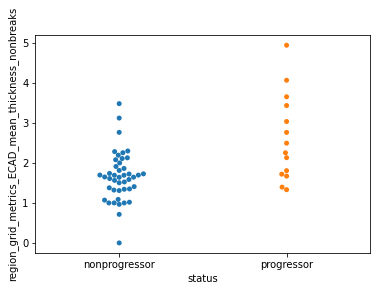

In [37]:
f = feats.copy()
f['status'] = meta.loc[f.index]['Status']
sns.swarmplot(data=f, x='status', y='region_grid_metrics_ECAD_mean_thickness_nonbreaks')

<AxesSubplot:xlabel='status', ylabel='region_grid_metrics_ECAD_integrity'>

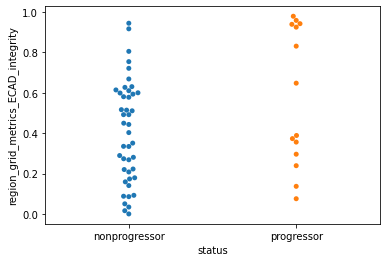

In [38]:
f = feats.copy()
f['status'] = meta.loc[f.index]['Status']
sns.swarmplot(data=f, x='status', y='region_grid_metrics_ECAD_integrity')

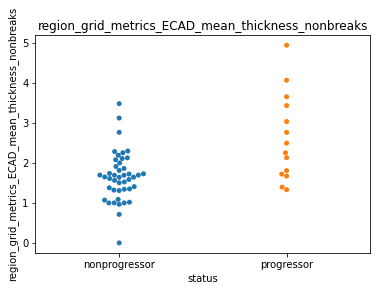

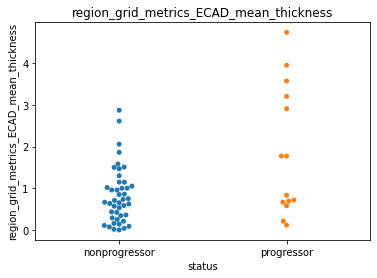

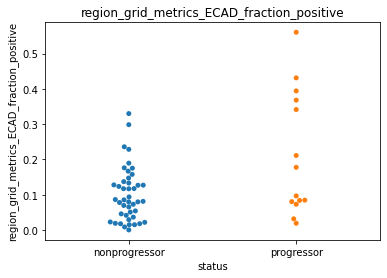

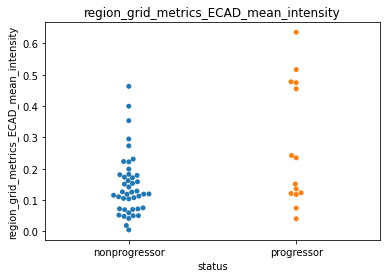

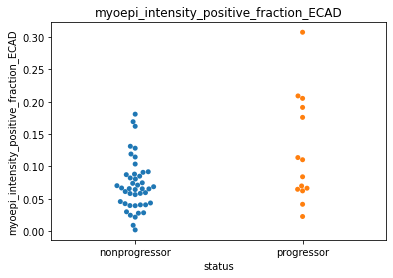

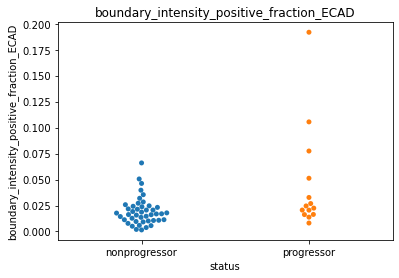

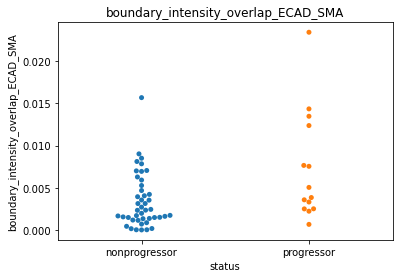

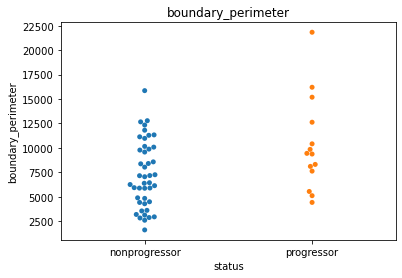

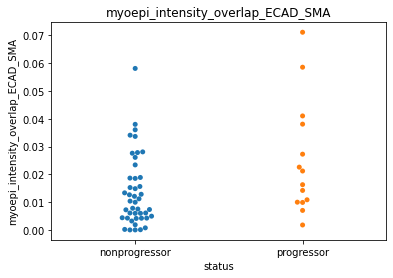

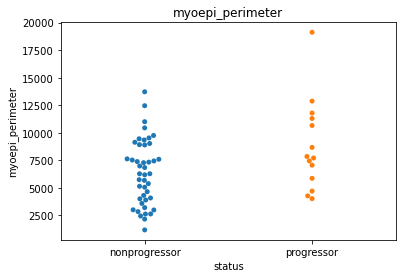

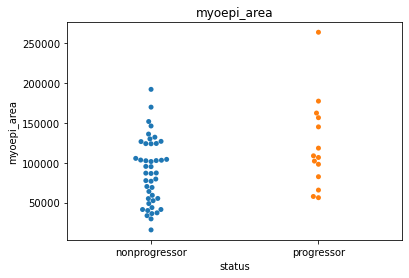

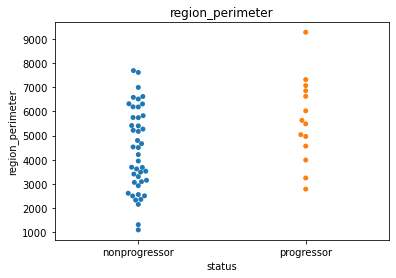

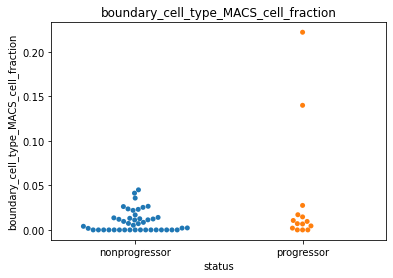

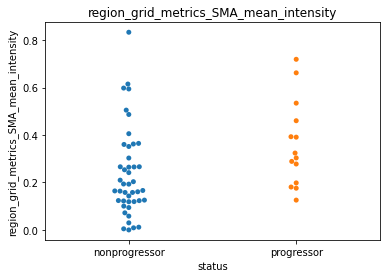

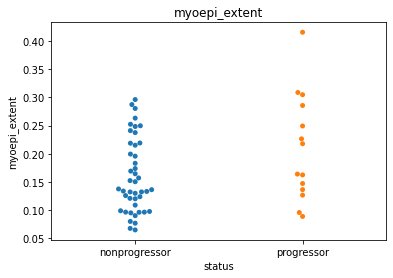

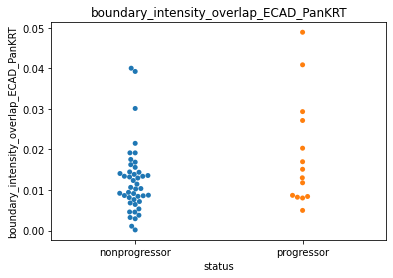

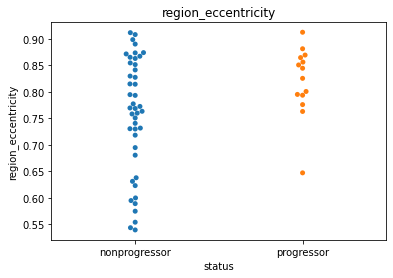

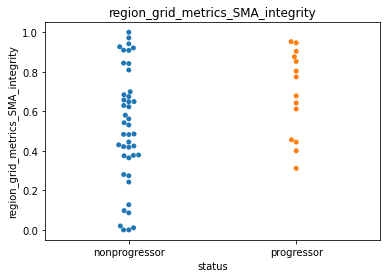

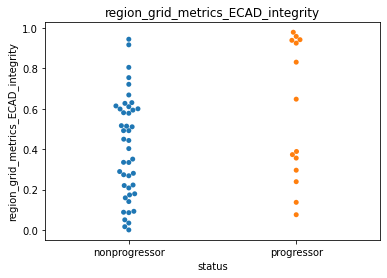

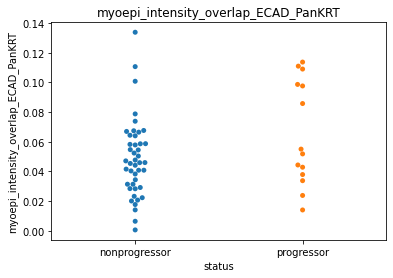

In [39]:
cols = df.sort_values('p-value')['feature'][:20]
for c in cols:
    sns.swarmplot(data=f, x='status', y=c)
    plt.title(c)
    plt.show()
    

In [40]:
list(feats.columns)

['boundary_cell_type_APC_cell_fraction',
 'boundary_cell_type_BCELL_cell_fraction',
 'boundary_cell_type_CAF_cell_fraction',
 'boundary_cell_type_CD4T_cell_fraction',
 'boundary_cell_type_CD8T_cell_fraction',
 'boundary_cell_type_DC_cell_fraction',
 'boundary_cell_type_ENDO_cell_fraction',
 'boundary_cell_type_FIBRO_VIMonly_cell_fraction',
 'boundary_cell_type_IMMUNEOTHER_cell_fraction',
 'boundary_cell_type_MACS_cell_fraction',
 'boundary_cell_type_MAST_cell_fraction',
 'boundary_cell_type_MONODC_cell_fraction',
 'boundary_cell_type_MONO_cell_fraction',
 'boundary_cell_type_MYOEP_cell_fraction',
 'boundary_cell_type_MYOFIBRO_cell_fraction',
 'boundary_cell_type_NEUT_cell_fraction',
 'boundary_cell_type_NORMFIBRO_cell_fraction',
 'boundary_cell_type_OTHER_cell_fraction',
 'boundary_cell_type_TCELL_cell_fraction',
 'boundary_cell_type_TUMOR_CK5_cell_fraction',
 'boundary_cell_type_TUMOR_ECADCK_cell_fraction',
 'boundary_cell_type_TUMOR_EMT_cell_fraction',
 'boundary_cell_type_TUMOR_LUMI

Text(0.5, 1.0, 'myoepi_intensity_overlap_CK5_SMA')

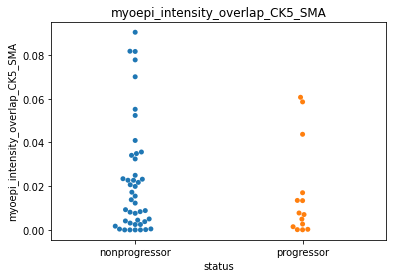

In [49]:
sns.swarmplot(data=f, x='status', y='myoepi_intensity_overlap_CK5_SMA')
plt.title('myoepi_intensity_overlap_CK5_SMA')

Text(0.5, 1.0, 'myoepi_intensity_overlap_CK5_SMA')

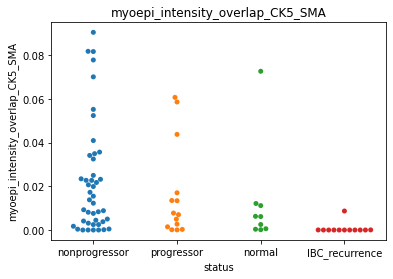

In [52]:
f = reduced.copy()
f['status'] = meta.loc[f.index]['Status']
order = ['nonprogressor', 'progressor', 'normal', 'IBC_recurrence']
sns.swarmplot(data=f, x='status', y='myoepi_intensity_overlap_CK5_SMA', order=order)
plt.title('myoepi_intensity_overlap_CK5_SMA')

Text(0.5, 1.0, 'myoepi_intensity_overlap_ECAD_SMA')

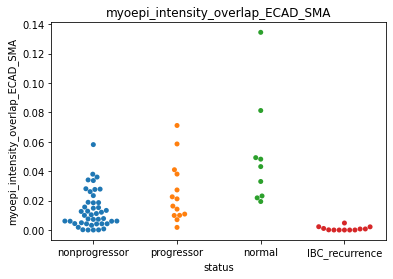

In [54]:
sns.swarmplot(data=f, x='status', y='myoepi_intensity_overlap_ECAD_SMA', order=order)
plt.title('myoepi_intensity_overlap_ECAD_SMA')

Text(0.5, 1.0, 'region_grid_metrics_SMA_integrity')

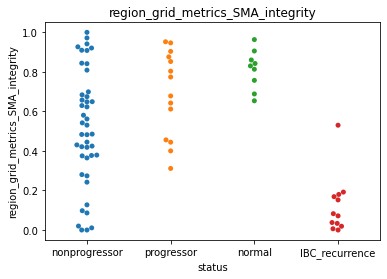

In [55]:
sns.swarmplot(data=f, x='status', y='region_grid_metrics_SMA_integrity', order=order)
plt.title('region_grid_metrics_SMA_integrity')

In [45]:
df = reduced.copy()
df['status'] = meta.loc[df.index]['Status']
df = df.groupby('status').mean()
df

boundary_cell_type_APC_cell_fraction  \
status                                                 
IBC_recurrence                              0.062113   
nonprogressor                               0.059685   
normal                                      0.022215   
progressor                                  0.045920   

                boundary_cell_type_BCELL_cell_fraction  \
status                                                   
IBC_recurrence                                0.001815   
nonprogressor                                 0.004460   
normal                                        0.013555   
progressor                                    0.015564   

                boundary_cell_type_CAF_cell_fraction  \
status                                                 
IBC_recurrence                              0.061776   
nonprogressor                               0.047810   
normal                                      0.004714   
progressor                                  0.027293   

                boundary_cell_type_CD4T_cell_fraction  \
status                                                  
IBC_recurrence                               0.008715   
nonprogressor                                0.029034   
normal                                       0.013397   
progressor                                   0.036983   

                boundary_cell_type_CD8T_cell_fraction  \
status                                                  
IBC_recurrence                               0.019771   
nonprogressor                                0.014595   
normal                                       0.011659   
progressor                                   0.017630   

                boundary_cell_type_DC_cell_fraction  \
status                                                
IBC_recurrence                             0.010401   
nonprogressor                              0.007416   
normal                                     0.001014   
progressor                                 0.008515   

                boundary_cell_type_ENDO_cell_fraction  \
status                                                  
IBC_recurrence                               0.034489   
nonprogressor                                0.074996   
normal                                       0.033598   
progressor                                   0.059155   

                boundary_cell_type_FIBRO_VIMonly_cell_fraction  \
status                                                           
IBC_recurrence                                        0.043751   
nonprogressor                                         0.103824   
normal                                                0.151278   
progressor                                            0.094112   

                boundary_cell_type_IMMUNEOTHER_cell_fraction  \
status                                                         
IBC_recurrence                                      0.021362   
nonprogressor                                       0.020007   
normal                                              0.015812   
progressor                                          0.020090   

                boundary_cell_type_MACS_cell_fraction  ...  \
status                                                 ...   
IBC_recurrence                               0.037857  ...   
nonprogressor                                0.009850  ...   
normal                                       0.004541  ...   
progressor                                   0.032981  ...   

                region_intensity_overlap_ECAD_PanKRT  \
status                                                 
IBC_recurrence                              0.105315   
nonprogressor                               0.180370   
normal                                      0.194298   
progressor                                  0.186522   

                region_intensity_overlap_ECAD_SMA  \
status                                              
IBC_recurrence                     

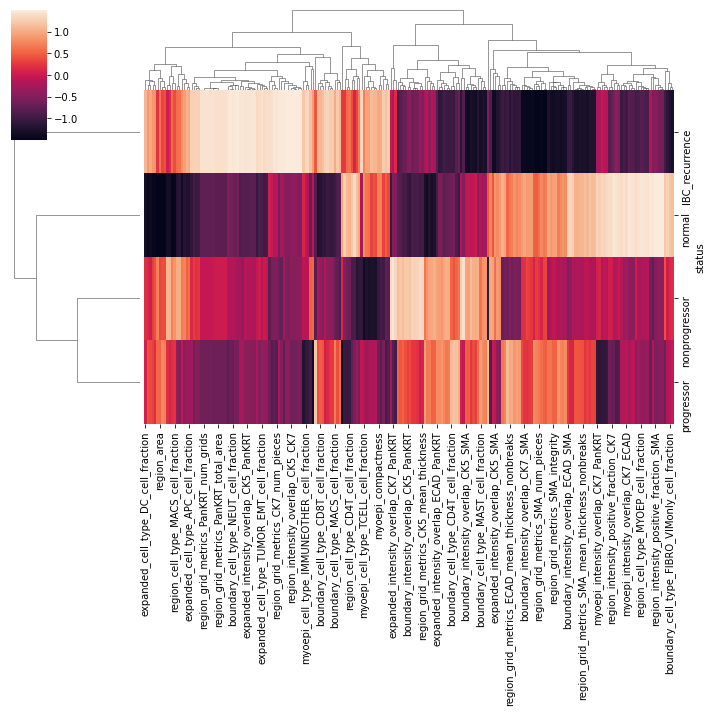

In [46]:
sns.clustermap(df, z_score=True)

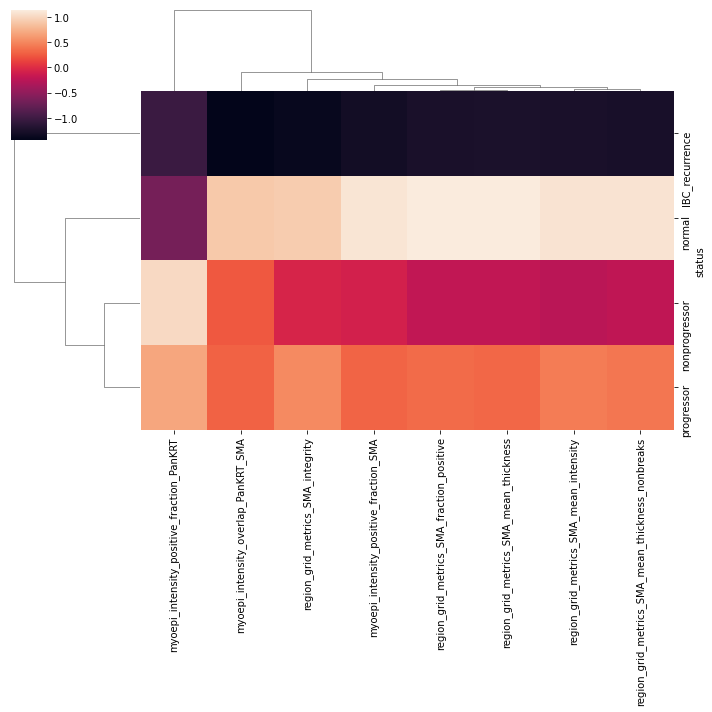

In [47]:
cols = ['region_grid_metrics_SMA_fraction_positive',
 'region_grid_metrics_SMA_integrity',
 'region_grid_metrics_SMA_mean_intensity',
 'region_grid_metrics_SMA_mean_thickness',
 'region_grid_metrics_SMA_mean_thickness_nonbreaks',
 'myoepi_intensity_overlap_PanKRT_SMA',
 'myoepi_intensity_positive_fraction_PanKRT',
 'myoepi_intensity_positive_fraction_SMA',
]
sns.clustermap(df[cols], z_score=True)

In [56]:
fps = sorted(listfiles(directory, regex='/regions.npy$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2203/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2204/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2302/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2303/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2304/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2305/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2306/outputs/regions.npy',
 '/diskmnt/Projects/Users/estorr

In [57]:
sample_to_imgs = {}
for fp in fps:
    sample = fp.split('/')[-3]
    d = np.load(fp, allow_pickle=True)[()]
    sample_to_imgs[sample] = d
    

In [58]:
fps = sorted(listfiles(directory, regex='/grid_regions.npy$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2203/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2204/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2302/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2303/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2304/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2305/outputs/grid_regions.npy',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2306/outputs/grid_region

In [59]:
sample_to_grid_imgs = {}
for fp in fps:
    sample = fp.split('/')[-3]
    d = np.load(fp, allow_pickle=True)[()]
    sample_to_grid_imgs[sample] = d

In [60]:
fps = sorted(listfiles(directory, regex='/grid_polygons.json$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2203/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2204/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2302/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2303/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2304/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2305/outputs/grid_polygons.json',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2306/outpu

In [61]:
sample_to_polys = {}
for fp in fps:
    sample = fp.split('/')[-3]
    d = json.load(open(fp))
    sample_to_polys[sample] = d

In [63]:
len(sample_to_imgs)

79

In [65]:
status_to_samples = {s:meta[meta['Status']==s].index.to_list() for s in set(meta['Status'])}
status_to_samples

{'progressor': ['Point2306',
  'Point2310',
  'Point2312',
  'Point2322',
  'Point3105',
  'Point3123',
  'Point5303',
  'Point5310',
  'Point6102',
  'Point6103',
  'Point6201',
  'Point6202',
  'Point6203',
  'Point6204'],
 'nonprogressor': ['Point2203',
  'Point2204',
  'Point2206',
  'Point2302',
  'Point2303',
  'Point2304',
  'Point2309',
  'Point2311',
  'Point2313',
  'Point2318',
  'Point2319',
  'Point2320',
  'Point2321',
  'Point2325',
  'Point2326',
  'Point2327',
  'Point2328',
  'Point2331',
  'Point3102',
  'Point3104',
  'Point3107',
  'Point3108',
  'Point3110',
  'Point3111',
  'Point3112',
  'Point3114',
  'Point3115',
  'Point3117',
  'Point3119',
  'Point3120',
  'Point3121',
  'Point3125',
  'Point3128',
  'Point3129',
  'Point4410',
  'Point4411',
  'Point5202',
  'Point5302',
  'Point5304',
  'Point5305',
  'Point5306',
  'Point5308',
  'Point5309',
  'Point6206'],
 'IBC_recurrence': ['Point4103',
  'Point4106',
  'Point4115',
  'Point4116',
  'Point4117',
  'P

In [66]:
for k, v in status_to_samples.items(): print(k, len(v))

progressor 14
nonprogressor 44
IBC_recurrence 12
normal 9


In [88]:
axs

array([<AxesSubplot:title={'center':'Point2306'}>,
       <AxesSubplot:title={'center':'Point2310'}>,
       <AxesSubplot:title={'center':'Point2312'}>,
       <AxesSubplot:title={'center':'Point2322'}>,
       <AxesSubplot:title={'center':'Point3105'}>,
       <AxesSubplot:title={'center':'Point3123'}>,
       <AxesSubplot:title={'center':'Point5303'}>,
       <AxesSubplot:title={'center':'Point5310'}>,
       <AxesSubplot:title={'center':'Point6102'}>,
       <AxesSubplot:title={'center':'Point6103'}>,
       <AxesSubplot:title={'center':'Point6201'}>,
       <AxesSubplot:title={'center':'Point6202'}>,
       <AxesSubplot:title={'center':'Point6203'}>,
       <AxesSubplot:title={'center':'Point6204'}>, <AxesSubplot:>],
      dtype=object)

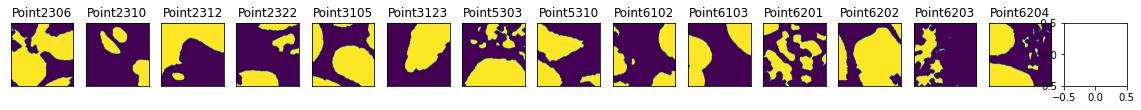

In [92]:
status = 'progressor'
fig, axs = plt.subplots(nrows=1, ncols=15, figsize=(20, 5))
axs = axs.flatten()
for (s, d), ax in list(zip({k:v for k, v in sample_to_imgs.items() if k in status_to_samples[status]}.items(), axs)):
    img = d['region']['mask']
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])
axs[-1].imshow(np.ones((1,1,3)))

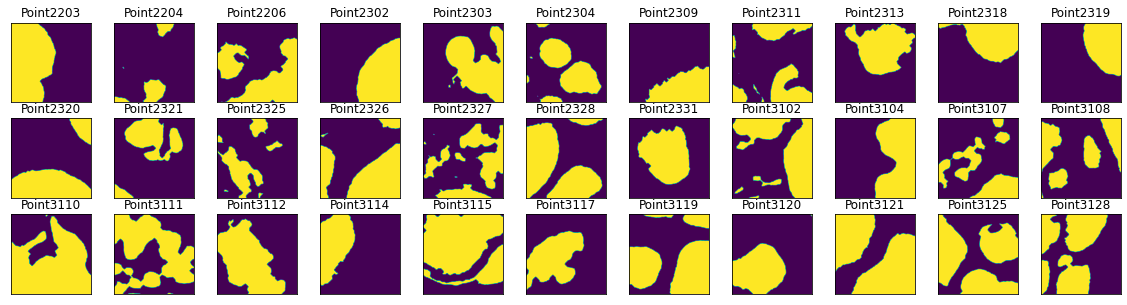

In [73]:
status = 'nonprogressor'
fig, axs = plt.subplots(nrows=3, ncols=11, figsize=(20, 5))
axs = axs.flatten()
for (s, d), ax in list(zip({k:v for k, v in sample_to_imgs.items() if k in status_to_samples[status]}.items(), axs)):
    img = d['region']['mask']
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

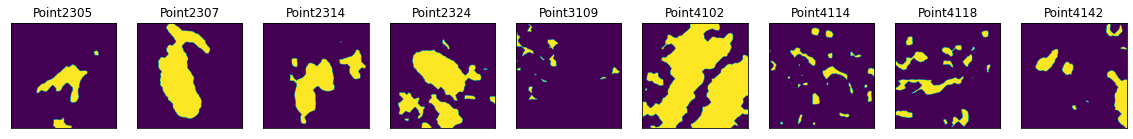

In [74]:
status = 'normal'
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20, 5))
axs = axs.flatten()
for (s, d), ax in list(zip({k:v for k, v in sample_to_imgs.items() if k in status_to_samples[status]}.items(), axs)):
    img = d['region']['mask']
    ax.imshow(img)
    ax.set_title(s)
    ax.set_xticks([])
    ax.set_yticks([])

In [83]:
region_to_bbox = {reg:(r1, c1, r2, c2) for reg, r1, c1, r2, c2 in zip(
                    combined.index.to_list(),
                    combined['boundary_bbox-0'], combined['boundary_bbox-1'],
                    combined['boundary_bbox-2'], combined['boundary_bbox-3'])}

In [110]:
def get_display_image(s, labeled, region_to_bbox,
                      color='region_grid_metrics_SMA_integrity', cmap='viridis', df=None,
                      vmin=None, vmax=None):
    if df is None:
        df = combined

    f = df[df['sample']==s]
    f.index = [x.split('_')[-1] for x in f.index]
    rbbox = {reg.split('_')[-1]:tup for reg, tup in region_to_bbox.items() if s in reg} if region_to_bbox is not None else None
    region_to_val = {reg:v
                     for reg, v in zip(f.index, f[color])}
    rgba = display_region(labeled, region_to_val, rbbox, cmap=cmap, vmin=vmin, vmax=vmax)
    return rgba

In [112]:
def plot_feature_wrapper(feat):
    df = combined.copy()
    
    vmin, vmax = df[feat].min(), df[feat].max()
    df['status'] = [meta.loc[x, 'Status'] for x in df['sample']]
    for status in ['progressor', 'nonprogressor', 'normal']:
        print(status)
        f = df[df['status']==status]
        s2i = {k:v for k, v in sample_to_imgs.items() if k in status_to_samples[status]}
        nrows = (len(s2i) // 15) + 1
        fig, axs = plt.subplots(nrows=nrows, ncols=15, figsize=(20, nrows * 1.5))
        axs = axs.flatten()
        for (s, d), ax in zip(s2i.items(), axs):
            labeled = s2i[s]['region']['labeled']
            img = get_display_image(s, labeled, None, color=feat, df=f, vmin=vmin, vmax=vmax)
            ax.imshow(img)
            ax.set_title(s)

        for ax in axs[len(s2i):]:
            ax.imshow(np.ones((1,1,3)))

        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()
    
    

progressor


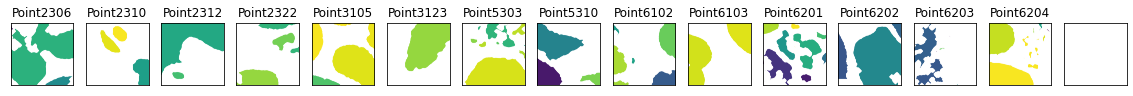

nonprogressor


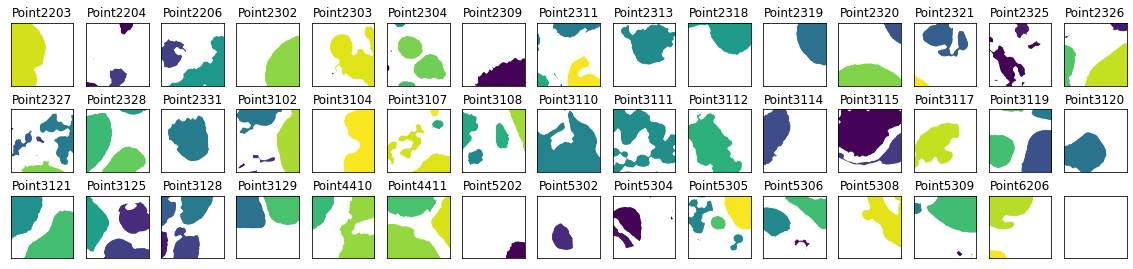

normal


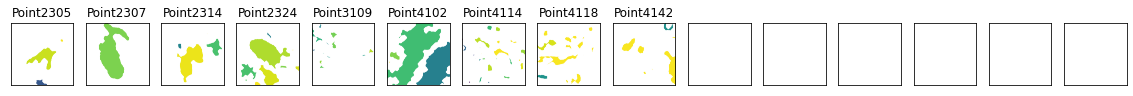

In [113]:
plot_feature_wrapper('region_grid_metrics_SMA_integrity')

progressor


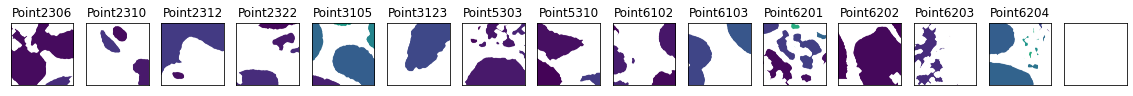

nonprogressor


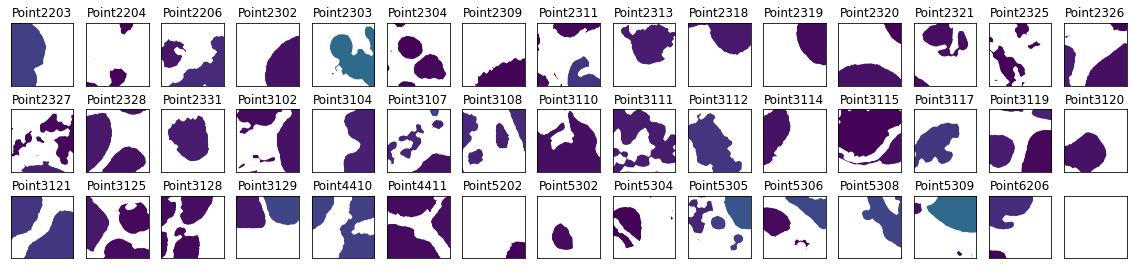

normal


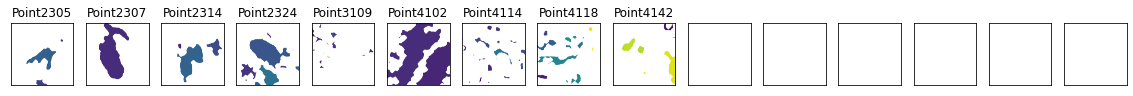

In [150]:
plot_feature_wrapper('myoepi_intensity_overlap_ECAD_SMA')

In [129]:
sns.color_palette('tab10')[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [140]:
np.expand_dims(sns.color_palette('tab10')[0], 0)

array([[0.12156863, 0.46666667, 0.70588235]])

In [222]:
from skimage.exposure import rescale_intensity
def make_pseudo(channel_to_img, cmap=None, contrast_pct=95.):
    cmap = sns.color_palette('tab10') if cmap is None else cmap
    
    new = np.zeros_like(next(iter(channel_to_img.values())))
    img_stack = []
    for i, (channel, img) in enumerate(channel_to_img.items()):
        color = cmap[i] if not isinstance(cmap, dict) else cmap[channel]
        new = img.copy().astype(np.float32)
        new -= new.min()
        new /= new.max()
        vmax = np.percentile(new[new>0], (contrast_pct))
        new = rescale_intensity(new, in_range=(0., vmax))

        new = np.repeat(np.expand_dims(new, -1), 3, axis=-1)
        new *= color
        img_stack.append(new)
    stack = np.mean(np.asarray(img_stack), axis=0)
    stack -= stack.min()
    stack /= stack.max()
    return stack


In [219]:
channel_to_img = extract_ome_tiff(
    '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2320/inputs/2320.ome.tiff',
    channels=['SMA', 'Nuc', 'ECAD'])
channel_to_img.keys()

dict_keys(['ECAD', 'Nuc', 'SMA'])

In [220]:
cmap = {
    'Nuc': (0., 0., 1.),
    'ECAD': (1., 0., 0.),
    'SMA': (0., 1., 0.)
}

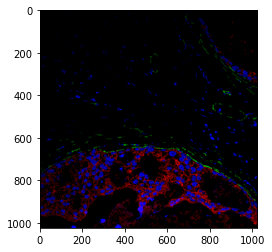

In [223]:
pseudo = make_pseudo(channel_to_img, cmap)
plt.imshow(pseudo)

In [114]:
channel_to_img = extract_ome_tiff('../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2320/inputs/2320.ome.tiff')
channel_to_img.keys()

dict_keys(['AR', 'Au', 'Aumaskf', 'Background', 'C', 'CD11c', 'CD14', 'CD20', 'CD3', 'CD31', 'CD36', 'CD4', 'CD44', 'CD45', 'CD56', 'CD68', 'CD8', 'CK5', 'CK7', 'COLI', 'COX2', 'Ca40', 'ECAD', 'ER', 'FAP', 'FOXP3', 'GLUT1', 'GZMB', 'HER2', 'HH3', 'HIF1a', 'HLADRDPDQ', 'IDO1', 'Ki67', 'MMP9', 'MPO', 'Nuc', 'P', 'P63', 'PD1', 'PDL1', 'PanKRT', 'SMA', 'Tryptase', 'VIM', 'pS6'])

In [224]:
fps = sorted(listfiles('../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/', regex=r'ome.tiff'))
fps

['../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2203/inputs/2203.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2204/inputs/2204.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/inputs/2206.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2302/inputs/2302.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2303/inputs/2303.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2304/inputs/2304.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2305/inputs/2305.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2306/inputs/2306.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2307/inputs/2307.ome.tiff',
 '../../multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2309/inputs/2309.ome.tiff',
 '../../multiplex_data/analysis/dcis_reg

In [ ]:
cmap = {
    'Nuc': (0., 0., 1.),
    'ECAD': (1., 0., 0.),
    'SMA': (0., 1., 0.)
}
sample_to_pseudo = {}
for fp in fps:
    sid = fp.split('/')[-3]
    c2i = extract_ome_tiff(fp, channels=['SMA', 'Nuc', 'ECAD'])
    pseudo = make_pseudo(c2i, cmap)
plt.imshow(pseudo)

progressor


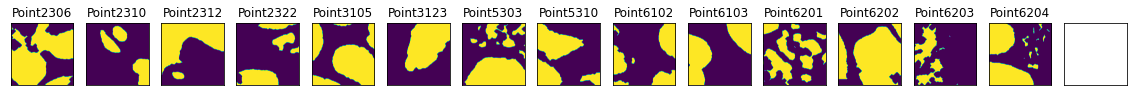

nonprogressor


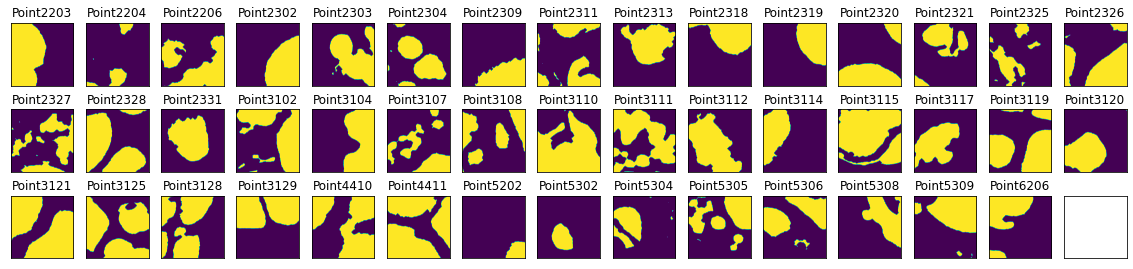

normal


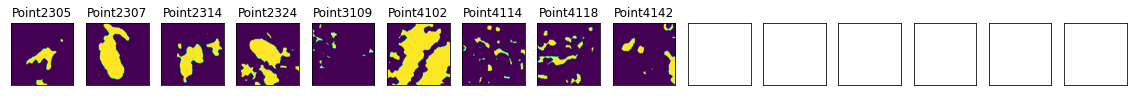

In [98]:
df = combined.copy()
df['status'] = [meta.loc[x, 'Status'] for x in df['sample']]
for status in ['progressor', 'nonprogressor', 'normal']:
    print(status)
    f = df[df['status']==status]
    s2i = {k:v for k, v in sample_to_imgs.items() if k in status_to_samples[status]}
    nrows = (len(s2i) // 15) + 1
    fig, axs = plt.subplots(nrows=nrows, ncols=15, figsize=(20, nrows * 1.5))
    axs = axs.flatten()
    for (s, d), ax in zip(s2i.items(), axs):
        labeled = s2i[s]['region']['labeled']
#         img = get_display_image(s, labeled, region_to_bbox,
#                                 color='region_grid_metrics_SMA_integrity', df=f)
#         ax.imshow(img)
        ax.imshow(labeled>0)
        ax.set_title(s)
    
    for ax in axs[len(s2i):]:
        ax.imshow(np.ones((1,1,3)))
        
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
    

In [79]:
sid = 'Point2206'

In [80]:
'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/inputs/2206.ome.tiff'

'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v4/Point2206/inputs/2206.ome.tiff'

In [81]:
tifffile.imsave(f'/diskmnt/Projects/Users/estorrs/sandbox/{sid}_region.tif', sample_to_imgs[sid]['region']['mask'])

In [82]:
tifffile.imsave(f'/diskmnt/Projects/Users/estorrs/sandbox/{sid}_myoepi.tif', sample_to_imgs[sid]['myoepi']['mask'])